# TODO: 
## Must
- [ ] Implement learning curve plot for different model complexities and parameters
- [ ] Implement ensemble methods for classification
- [ ] Use clustering metrics

## Should

## Nice to do
- [ ] More classification models

# 1. Προετοιμασία δεδομένων

#### 1.0 Import τα απατούμενα packages της Python

In [235]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from tqdm.notebook import tqdm

from collections import Counter

from neural_network_classifier import OscarClassificationNeuralNetwork, accuracy_fn

from helper_functions import plot_roc_curves, avg_classification_reports
# from google.colab import drive
# drive.mount('/content/drive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.1 Φόρτωση των δεδομένων
Φορτώνουμε τα δεδομένα από το αρχείο `movies.xlsx` σε ένα pandas dataframe.

In [236]:
pd.set_option('display.max_columns', None)

# Truncate
pd.set_option('display.max_rows', False) # Change False to None to not truncate

In [237]:
df = pd.read_excel('movies.xlsx')
last_idx = len(df) - 1

df_un_orig = pd.read_excel('movies_test_anon_sample.xlsx')
# df_unkwn = pd.read_excel('movies_test_anon_sample.xlsx')

# Concat two dataframes
df = pd.concat([df, df_un_orig.drop(['ID'], axis=1)])

Μετονομάζουμε τις στήλες σε πιο χρήσιμα ονόματα αφαιρώντας τα επιπλέον κενά. 

In [238]:
# remove double spaces, leading and trailing spaces and replace them with _ and convert to lowercase
new_names_dict = dict(zip(df.columns, list(x.strip().replace(" ", "_").replace("__", "_").lower() for x in df.columns)))

# replace df_unkwn_unkwn_unkwn_unkwn columns
df = df.rename(columns=new_names_dict)

## 1.2 Γενική εικόνα των δεδομένων
Βλέπουμε το περιεχόμενο του dataframe εμφανίζοντας τις πρώτες 5 γραμμές.

In [239]:
# split
df_un = df.iloc[last_idx+1:]
df = df.iloc[:last_idx+1]

Τα βασικά χαρακτηριστικά του dataframe όπως τον αριθμό των γραμμών και τον τύπο των δεδομένων της κάθε στήλης.

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1402 entries, 0 to 1401
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   film                                    1402 non-null   object 
 1   year                                    1402 non-null   int64  
 2   script_type                             1402 non-null   object 
 3   rotten_tomatoes_critics                 1401 non-null   object 
 4   metacritic_critics                      1402 non-null   object 
 5   average_critics                         1402 non-null   object 
 6   rotten_tomatoes_audience                1401 non-null   float64
 7   metacritic_audience                     1402 non-null   object 
 8   rotten_tomatoes_vs_metacritic_deviance  1402 non-null   object 
 9   average_audience                        1402 non-null   object 
 10  audience_vs_critics_deviance            1402 non-null   object 
 

Βασικά στατιστικά των στηλών που περιλαμβάνων αριθμητικούς τύπους δεδομένων όπως τη μέση τιμή και τη κανονική κατανομή.  

In [241]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1402.0,2012.140514,3.190291,2007.0,2009.00,2012.000,2015.00,2017.00
rotten_tomatoes_audience,1401.0,62.122769,17.435737,17.0,49.00,62.000,76.00,98.00
domestic_gross_($million),1402.0,74.058024,87.389737,0.0,21.09,44.045,92.59,936.66
imdb_rating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imdb_vs_rt_disparity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Κάποιες επιπλέον ιδιότητες του dataframe συμπεριλαμβανομένου και του τύπου δεδομένων `object`

In [242]:
df.describe(include='object').T

,count,unique,top,freq
film,1402,1396,Big Miracle,2
script_type,1402,17,original screenplay,546
rotten_tomatoes_critics,1401,102,93,29
metacritic_critics,1402,90,51,39
average_critics,1402,196,64,25
metacritic_audience,1402,78,66,50
rotten_tomatoes_vs_metacritic_deviance,1402,82,-1,58
average_audience,1402,116,58,45
audience_vs_critics_deviance,1402,78,-5,54
...,...,...,...,...


# 2. Καθάρισμα δεδομένων
Ελέγχουμε και αντιμετωπίζουμε **missing values**, **outliers** και **διπλότυπα**.


## 2.1 Έλεγχος για διπλότυπα

Ελέγχουμε για διπλότυπα με το όνομα της ταινίας.

In [243]:
df[df.duplicated(subset=['film'], keep=False)]

,film,year,script_type,rotten_tomatoes_critics,metacritic_critics,average_critics,rotten_tomatoes_audience,metacritic_audience,rotten_tomatoes_vs_metacritic_deviance,average_audience,audience_vs_critics_deviance,primary_genre,genre,opening_weekend,opening_weekend_($million),domestic_gross,domestic_gross_($million),foreign_gross_($million),foreign_gross,worldwide_gross,worldwide_gross_($million),of_gross_earned_abroad,budget_($million),budget_recovered,budget_recovered_opening_weekend,distributor,imdb_rating,imdb_vs_rt_disparity,release_date_(us),oscar_winners,oscar_detail
681,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.45,36931089,36.93,20.79,20788004,57719093,58.0,36.02%,70,82.46%,19.22%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
682,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.0,36931089,37.00,20.79,20788004,57719093,58.0,36.02%,70,82.46,18.57%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
703,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,7.76,20157300,20.16,4.56,4561915,24719215,25.0,18.45%,40,61.80%,19.40%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
704,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,8.0,20157300,20.00,4.56,4561915,24719215,25.0,18.45%,40,61.8,20.00%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
709,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.0,20275446,20.00,10.81,10808153,31083599,31.0,34.77%,35,88.81,17.14%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
710,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.03,20275446,20.28,10.81,10808153,31083599,31.0,34.77%,35,88.81%,17.23%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
713,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,0.74,16377274,16.38,11.88,11880786,28258060,28.0,42.04%,32,88.31%,2.30%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
714,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,1.0,16377274,16.00,11.88,11880786,28258060,28.0,42.04%,32,88.31,3.13%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
1001,The Good Dinosaur,2015,original screenplay,77,66,72,66.0,70,-4,68,4,NaN,Adventure,39155217,39.0,123087120,123.09,209.12,209120551,332207671,332.21,62.95%,200,166%,19.58%,NaN,NaN,NaN,"Nov 25, 2015",NaN,NaN
1062,The Big Short,2015,adaptation,87,81,84,89.0,89,0,89,-5,NaN,drama,10531026,10.53,60900477,60.90,41.80,41800000,102700477,103.0,40.70%,28,366.79%,37.61%,NaN,NaN,NaN,"December 11, 2015",NaN,NaN


Διαγραφή διπλότυπων

## 2.2 Απών τιμές
Ελέγχουμε για τυχών απών τιμές όπως `NaN` και `-`.

In [244]:
#Concat
df = pd.concat([df, df_un])

Μετατροπή άκυρων τιμών σε NaN

In [245]:
# replace white characters with NaN
df = df.replace(r'^-$', np.nan, regex=True)
#Count NaN values per column
df.isna().sum()

film                                         0
year                                         0
script_type                                 17
rotten_tomatoes_critics                      2
metacritic_critics                           6
average_critics                              4
rotten_tomatoes_audience                     1
metacritic_audience                          4
rotten_tomatoes_vs_metacritic_deviance       4
average_audience                             3
audience_vs_critics_deviance                 5
primary_genre                             1412
                                          ... 
worldwide_gross                              3
worldwide_gross_($million)                   3
of_gross_earned_abroad                      11
budget_($million)                           13
budget_recovered                            16
budget_recovered_opening_weekend            15
distributor                               1417
imdb_rating                               1417
imdb_vs_rt_di

Μετατροπή σε αριθμητικά

In [246]:
# Remove invalid characters from numerical strings
df = df.apply(lambda x: x.replace(',','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)
df = df.apply(lambda x: x.replace('%','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)

# Convert strings to numbers
df = df.apply(lambda x: pd.to_numeric(x) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)

Υπολογισμός NaN τιμών από άλλες τιμές όπου είναι εφικτό

In [247]:
df['metacritic_critics'] = df.apply(lambda row: row['average_critics'] * 2 - row['rotten_tomatoes_critics'] if pd.isnull(row['metacritic_critics']) and pd.notnull(row['average_critics']) else row['metacritic_critics'], axis=1)
df['average_critics'] = df.apply(lambda row: (row['rotten_tomatoes_critics'] + row['metacritic_critics']) / 2 if pd.isnull(row['average_critics']) else row['average_critics'], axis=1)
df['metacritic_audience'] = df.apply(lambda row: row['average_audience'] * 2 - row['rotten_tomatoes_audience'] if pd.isnull(row['metacritic_audience']) and pd.notnull(row['average_audience']) else row['metacritic_audience'], axis=1)
df['rotten_tomatoes_vs_metacritic_deviance'] = df.apply(lambda row: row['rotten_tomatoes_audience'] - row['metacritic_audience'] if pd.isnull(row['rotten_tomatoes_vs_metacritic_deviance']) and pd.notnull(row['rotten_tomatoes_audience']) and pd.notnull(row['metacritic_audience']) else row['rotten_tomatoes_vs_metacritic_deviance'], axis=1)
df['foreign_gross'] = df.apply(lambda row: row['worldwide_gross'] - row['domestic_gross'] if pd.isnull(row['foreign_gross']) and pd.notnull(['worldwide_gross']) and pd.notnull(['domestic_gross']) else row['foreign_gross'], axis=1)
df['foreign_gross_($million)'] = df.apply(lambda row: row['foreign_gross'] / 1000 if pd.isnull(row['foreign_gross_($million)']) and pd.notnull(row['foreign_gross']) else row['foreign_gross_($million)'], axis=1)
df['of_gross_earned_abroad'] = df.apply(lambda row: row['foreign_gross'] / row['worldwide_gross'] if pd.isnull(row['of_gross_earned_abroad']) and pd.notnull(row['foreign_gross']) and pd.notnull(row['worldwide_gross']) else row['foreign_gross_($million)'], axis=1)
df['budget_recovered'] = df.apply(lambda row: row['worldwide_gross_($million)'] / row['budget_($million)'] * 100 if pd.isnull(row['budget_recovered']) and pd.notnull(row['worldwide_gross_($million)']) and pd.notnull(row['budget_($million)']) else row['budget_recovered'], axis=1)
df['budget_recovered_opening_weekend'] = df.apply(lambda row: row['opening_weekend'] / row['worldwide_gross'] * 100 if pd.isnull(row['budget_recovered_opening_weekend']) and pd.notnull(row['opening_weekend']) and pd.notnull(row['worldwide_gross']) else row['budget_recovered_opening_weekend'], axis=1)

Αντικατάσταση κατηγορηματικών τιμών

In [248]:
df['script_type'] = df['script_type'].fillna(df['script_type'].describe()['top'])
df['primary_genre'] = df['primary_genre'].fillna(df['primary_genre'].describe()['top'])
df['genre'] = df['genre'].fillna(df['genre'].describe()['top'])

Αντικατάσταση εναπομείναντων NaN τιμών με το μέσο όρο της στήλης όπου δεν είναι δυνατόν να υπολογιστεί.

In [249]:
df.loc[:, 'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'] = df.loc[:,  'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'].fillna(df.loc[:,  'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'].mean())
df.loc[:, 'opening_weekend' : 'budget_recovered_opening_weekend'] = df.loc[:,  'opening_weekend' : 'budget_recovered_opening_weekend'].fillna(df.loc[:,  'opening_weekend' : 'budget_recovered_opening_weekend'].mean())

## 2.3 Έλεγχος για outliers
Ελέγχουμε και διορθώνουμε τυχών outliers με πρώτο βήμα να μετατρέψουμε τις συμβολοσειρές σε κανονικές αριθμητικές μεταβλητές float ή integer. Επίσης μετατρέπουμε την στήλη `oscar_winners` σε 0 ή 1.

In [250]:
# Detect critic values outside normal range
df[(df['rotten_tomatoes_audience'] < 0) | (df['rotten_tomatoes_audience'] > 100) | (df['rotten_tomatoes_critics'] < 0) | (df['rotten_tomatoes_critics'] > 100)
   | (df['metacritic_critics'] < 0 ) | (df['metacritic_critics'] > 100) |  (df['metacritic_audience'] < 0 ) | (df['metacritic_audience']) > 100].sum()

film                                        0
year                                        0
script_type                                 0
rotten_tomatoes_critics                   0.0
metacritic_critics                        0.0
average_critics                           0.0
rotten_tomatoes_audience                  0.0
metacritic_audience                       0.0
rotten_tomatoes_vs_metacritic_deviance    0.0
average_audience                          0.0
audience_vs_critics_deviance              0.0
primary_genre                               0
                                         ... 
worldwide_gross                           0.0
worldwide_gross_($million)                0.0
of_gross_earned_abroad                    0.0
budget_($million)                         0.0
budget_recovered                          0.0
budget_recovered_opening_weekend          0.0
distributor                                 0
imdb_rating                               0.0
imdb_vs_rt_disparity              

Τελευταία διόρθωση συγκεκριμένων εσφαλμένων τιμών

In [251]:
df['budget_($million)'] = df.apply(lambda row: row['budget_($million)'] / 1000 if row['budget_($million)'] > 999 else row['budget_($million)'], axis=1)

# Convert 'of_gross_earned_abroad to 0-1 range
df['of_gross_earned_abroad'] = df['of_gross_earned_abroad'].apply(lambda s: s / 100)

Μία στατιστική εικόνα του dataframe με διορθωμένες αριθμητικές τιμές.

In [252]:
# df = df.reset_index()
# df = df.drop(['index'],axis=1)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
year,1452.00,2012.40,3.43,2007.00,2009.00,2012.00,2015.00,2022.00
rotten_tomatoes_critics,1452.00,53.60,27.52,0.00,29.00,54.00,78.00,100.00
metacritic_critics,1452.00,53.77,17.36,0.00,41.00,53.00,66.00,100.00
average_critics,1452.00,53.88,22.10,0.00,35.00,54.00,72.00,99.00
rotten_tomatoes_audience,1452.00,62.53,17.67,8.00,50.00,63.00,77.00,98.00
metacritic_audience,1452.00,62.76,13.62,2.00,54.00,64.00,73.00,92.00
rotten_tomatoes_vs_metacritic_deviance,1452.00,-0.18,13.11,-60.00,-8.00,0.00,7.00,84.00
average_audience,1452.00,62.81,14.49,5.00,53.00,63.00,74.00,93.00
audience_vs_critics_deviance,1452.00,-9.08,13.92,-48.00,-19.00,-8.00,1.00,33.00
...,...,...,...,...,...,...,...,...


# 3. Εξερεύνηση χαρακτηριστικών
Εξερευνούμε τα χαρακτηριστικά των δεδομένων εκτελώντας αλγόριθμούς υπολογισμού συσχετίσεων και PCA

## 3.1 Προεπεξεργασία των δεδομένων

Μετατροπή των στηλών `script_typr` και `genre` σε 1 hot encoding

In [253]:
# Make a copy of dataframe
df_cl = df

In [254]:
# Convert strings to lowercase
df_cl['script_type'] = df_cl['script_type'].str.lower()

# Extract all unique script type names
script_types = df_cl['script_type'].unique()

# Split strings and remove trailing spaces
types = []
for string in script_types:
    types.append(re.split(' / |, ',string))
script_types = [j.strip() for sub in types for j in sub]

#Convert to set to remove dublicates
unique_script_types = set(script_types)

# Insert columns for each coresponding script type
for i, item in enumerate(unique_script_types):
    # df.insert(i+1, 'st_'+item, 0)
    # df.insert(-1, 'st_'+item, 0)
    df_cl.insert(i, 'st_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for script in unique_script_types:
        if script in df_cl.at[i, 'script_type']:
            df_cl.at[i, 'st_'+script] = 1

# Drop script type and primary genre columns from dataframe
df_cl = df_cl.drop(['script_type'], axis=1)

In [255]:
# Convert genres to lower to avoid possible dublication
df_cl['genre'] = df_cl['genre'].str.lower()
genres = df_cl['genre'].unique()

# Split strings and remove trailing spaces
unique_genres = []
for string in genres:
    unique_genres.append(re.split(', |. ',string))
genre_types = [j.strip() for sub in unique_genres for j in sub]

#Convert to set to remove dublicates
genre_types = set(genre_types)

# Remove invalid values
genre_types.remove('')
genre_types.remove('adventur')
genre_types.remove('biograph')
genre_types.remove('comed')
genre_types.remove('crim')
genre_types.remove('documentar')
genre_types.remove('dram')
genre_types.remove('famiily')
genre_types.remove('famil')
genre_types.remove('fantas')
genre_types.remove('horro')
genre_types.remove('musi')
genre_types.remove('music')
genre_types.remove('myster')
genre_types.remove('romanti')
genre_types.remove('sci-f')
genre_types.remove('sport')
genre_types.remove('thriler')
genre_types.remove('thrille')

# Insert columns for each coresponding script type
for i, item in enumerate(genre_types):
    # df.insert(i+9, 'gen_'+item, 0)
    df_cl.insert(i, 'gen_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for genr in genre_types:
        if genr in df_cl.at[i, 'genre']:
            df_cl.at[i, 'gen_'+genr] = 1

# Drop original genre column
df_cl = df_cl.drop(['genre'], axis=1)

# Drop unecessary primary genre
df_cl = df_cl.drop(['primary_genre'], axis=1)

In [256]:
# Convert Oscar Winners to 1 hot encoding
df_cl['oscar_winners'] = df_cl["oscar_winners"].notnull().astype("int")

Μία γενική εικόνα του dataframe μετά τους μετασχηματισμούς

In [257]:
df_cl.head().T

,0,1,2,3,4
gen_horror,0,0,0,0,0
gen_documentary,0,0,0,0,0
gen_suspense,0,0,0,0,0
gen_family,0,0,0,0,0
gen_action,0,0,0,0,0
gen_drama,0,0,0,0,0
gen_comedy,0,0,0,0,0
gen_animation,0,0,0,0,0
gen_romance,0,0,0,0,0
...,...,...,...,...,...


## 3.2 Ανάλυση συσχετίσεων

### 3.2.1 Συσχέτιση χαρακτηριστικών με τη στήλη `oscar_winners`
Υπολογίζουμε την συσχέτιση με τη στήλη `oscar_winners` για να διαπιστώσουμε ποιο χαρακτηριστικό συμβάλει περισσότερο στο αν έχει πάρει oscar μία ταινία. Χωρίς έκπληξη διαπιστώνουμε ότι οι κριτικές έχουν τη μεγαλύτερη βαρύτητα όμως γενικά οί συσχετίσεις είναι μικρές.

In [258]:
# split
df_un_cl = df_cl.iloc[last_idx+1:]
df_cl = df_cl.iloc[:last_idx+1]
df_cl = df_cl.reset_index().drop(['index'], axis=1)

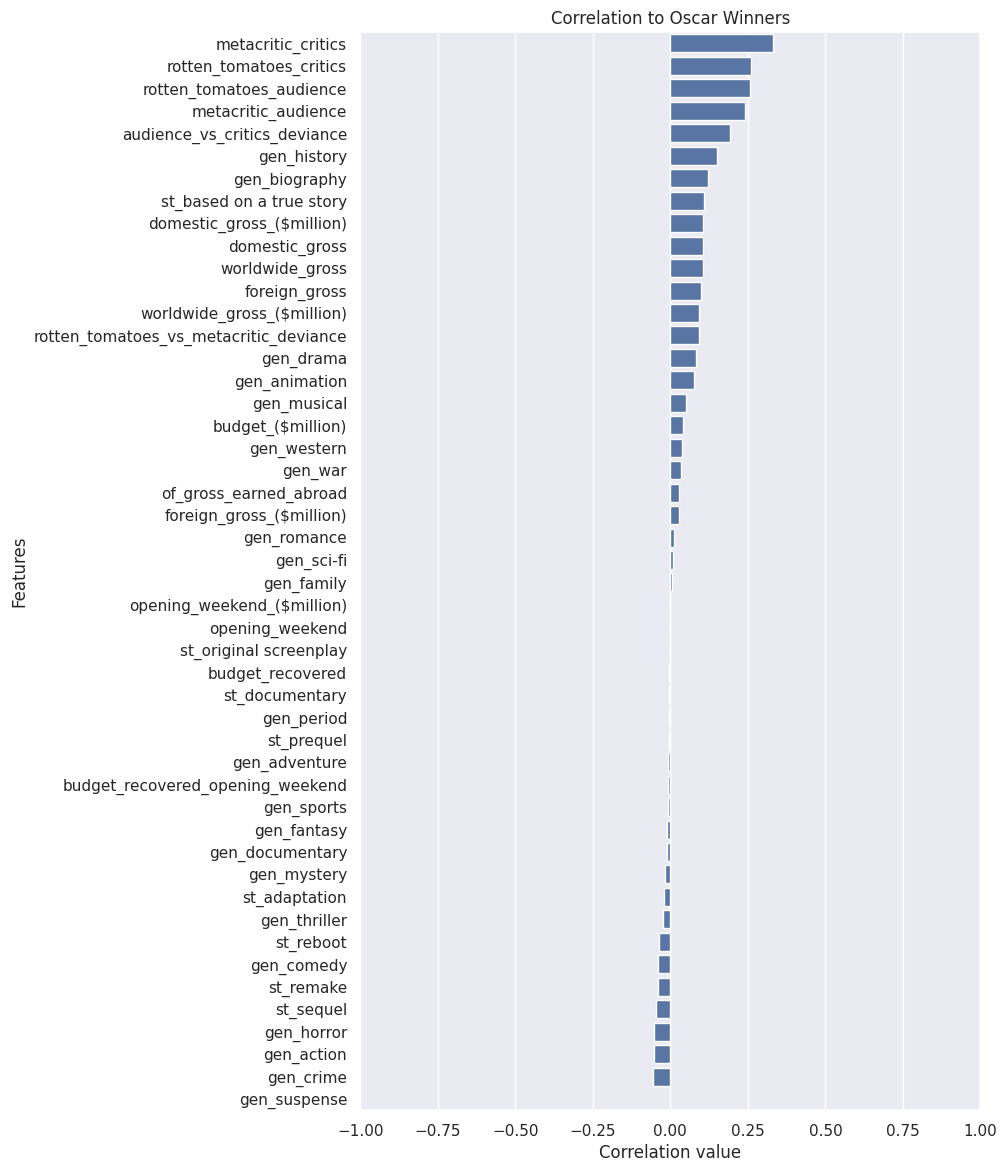

In [259]:
# remove non relevant columns
# df_cl_corr = df_cl.drop(['Film', 'Year','Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)','Oscar Detail'], axis=1)

# Remove non relevant columns and average critics columns
df_cl_corr = df_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail' , 'average_critics', 'average_audience'], axis=1)

# Calculate correlation values and grab last row
corr = df_cl_corr.corr()
last_row = pd.DataFrame(corr.iloc[-1, :-1]).sort_values(by='oscar_winners', ascending=False)

sns.set_theme()
plt.figure(figsize=(8, 14))
plt.title('Correlation to Oscar Winners')
plt.xlabel('Correlation value')
plt.ylabel('Features')
plt.xlim(-1, 1)
sns.barplot(data=last_row, x='oscar_winners', y=last_row.index)
plt.show()

### 3.2.2 Υπολογισμός Variance Inflation Factor
Υπολογίζουμε το Variance Inflation Factor των χαρακτηριστικών για να διαπιστώσουμε αν υπάρχει φαινόμενο multicollinearity. Σύμφωνα με το αποτέλεσμα υπάρχει τεράστιο φαινόμενο multicollinearity καθώς κάποιες τιμές είναι πολύ μεγάλες.


In [260]:
# TODO: Strategy for dealing with high multicollinearity ?

# Drop labels from set
X = df_cl_corr.drop(['oscar_winners'], axis=1)
  
# VIF dataframe
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
vif_data["VIF"] = vif_data["VIF"].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# pd.options.display.float_format = '{:.2f}'.format
vif_data

/home/mike/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/mike/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
44,of_gross_earned_abroad,inf
40,foreign_gross_($million),inf
39,domestic_gross_($million),3160978.43
38,domestic_gross,3160127.21
36,opening_weekend,515966.19
37,opening_weekend_($million),515958.68
33,metacritic_audience,13258.28
32,rotten_tomatoes_audience,12169.45
30,rotten_tomatoes_critics,10511.10
...,...,...


### 3.2.3 Πίνακας συσχέτισης
Υπολογίζουμε τον πίνακα συσχέτισης μεταξύ όλων των χαρακτηριστικών.

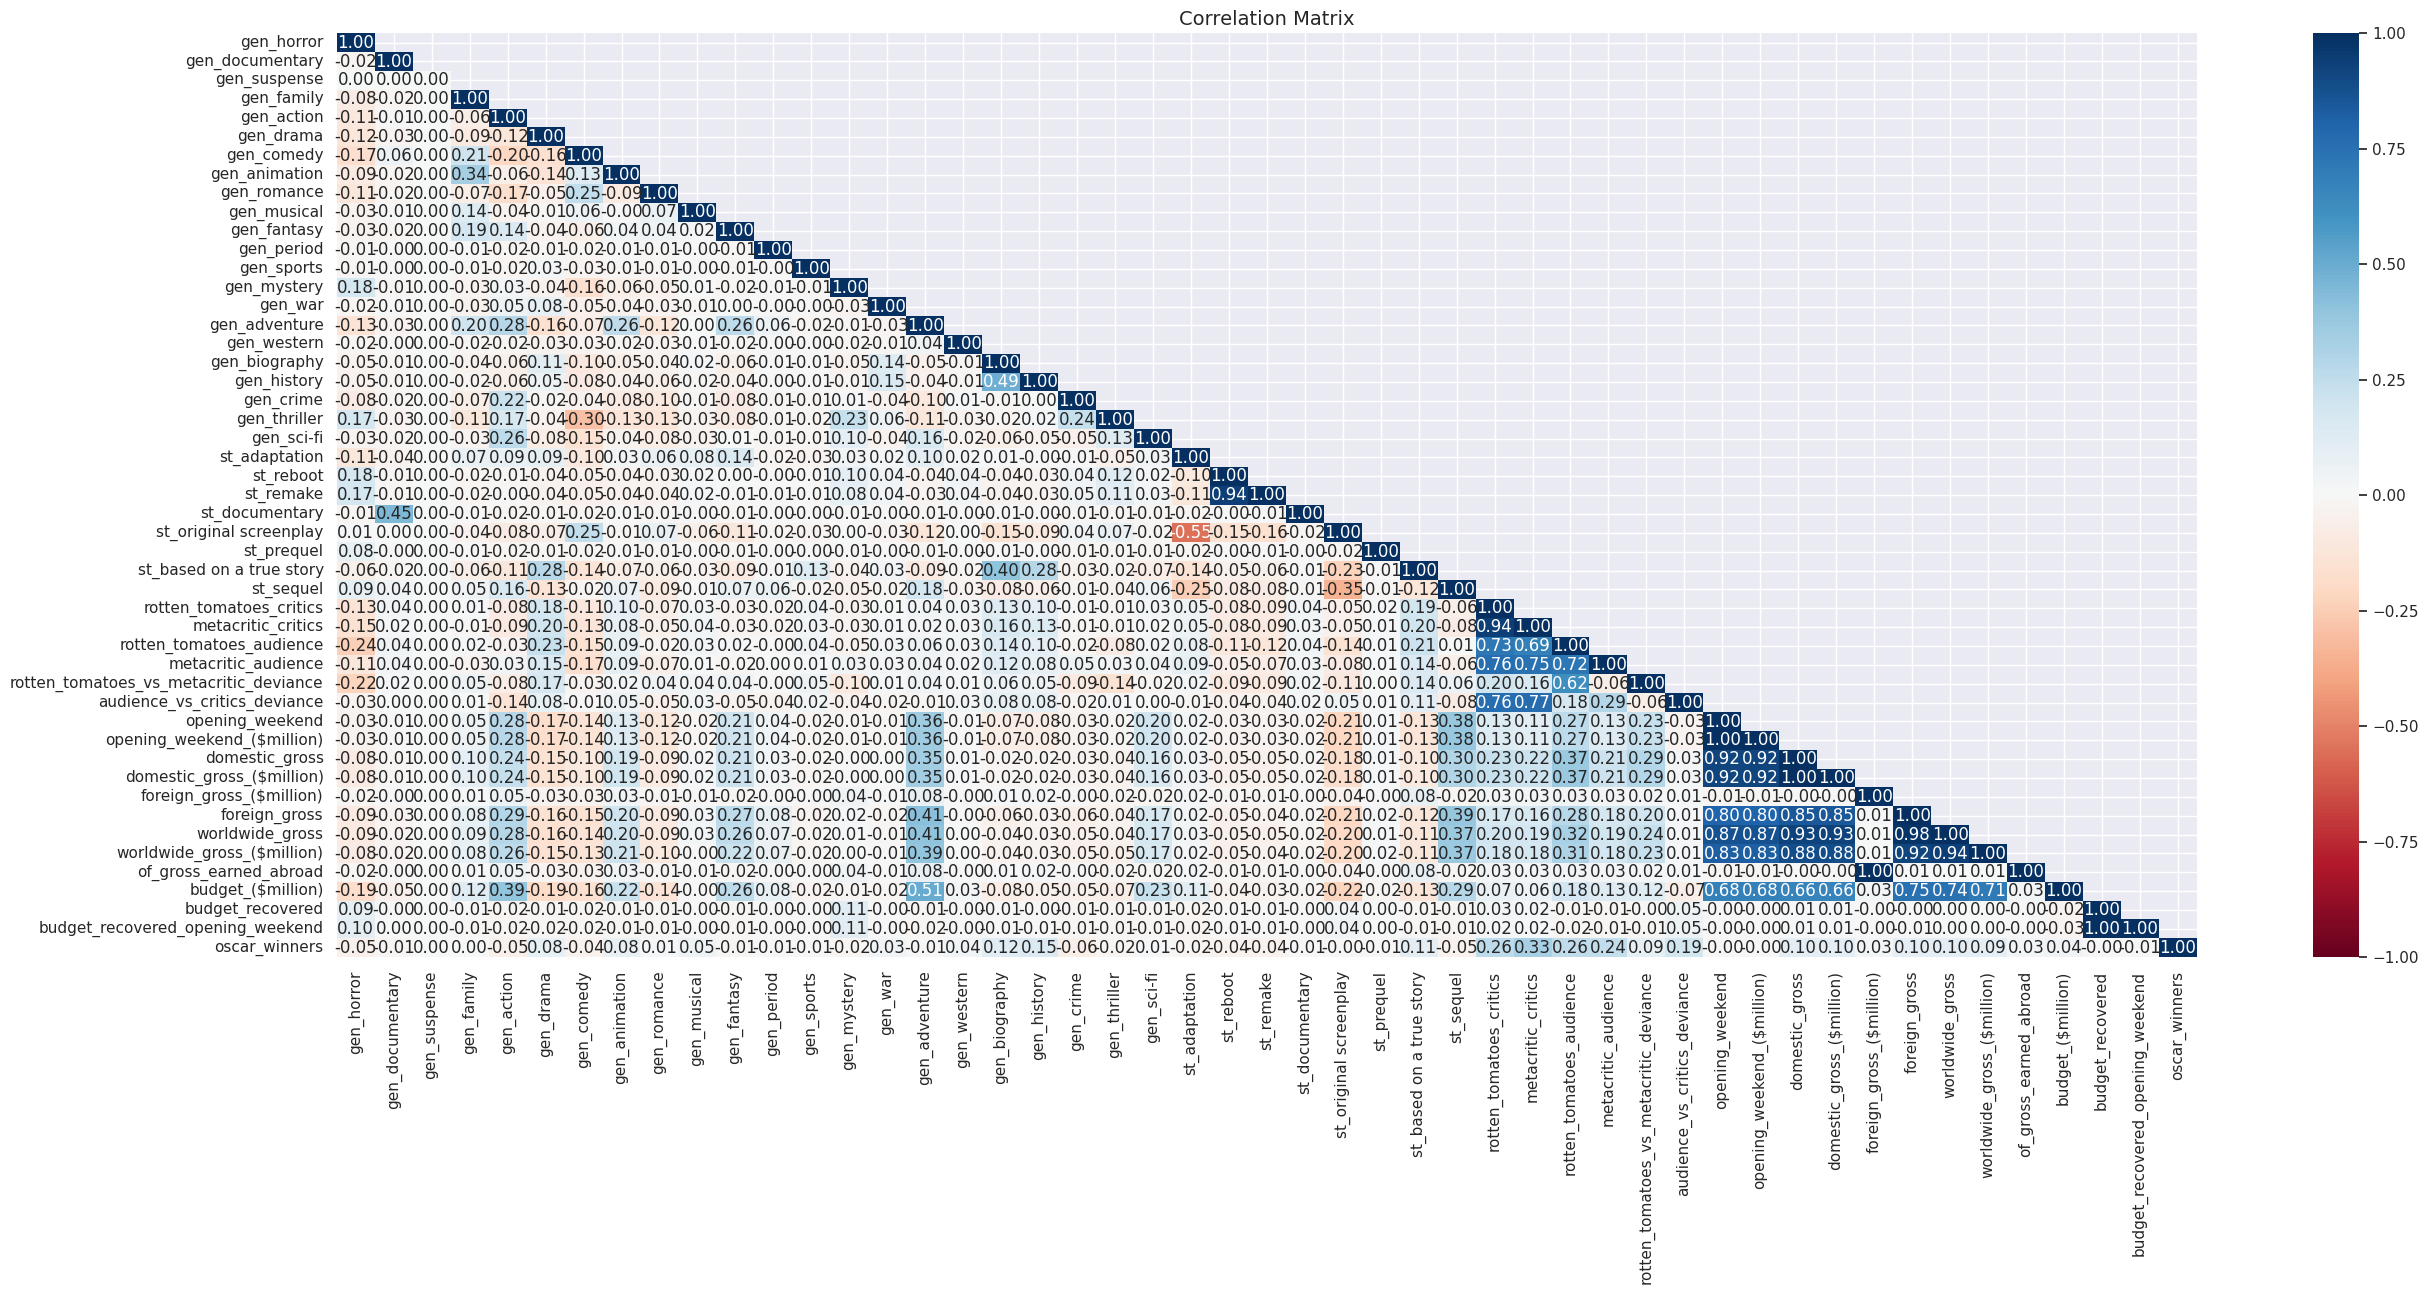

In [261]:
# Plot correlation matrix
corr_mat = df_cl_corr.corr()
corr_mat = corr_mat.fillna(0)

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
plt.figure(figsize=(30, 12))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### 3.2.4 Pairplot μεταξύ κάποιων σημαντικών χαρακτηριστικών.

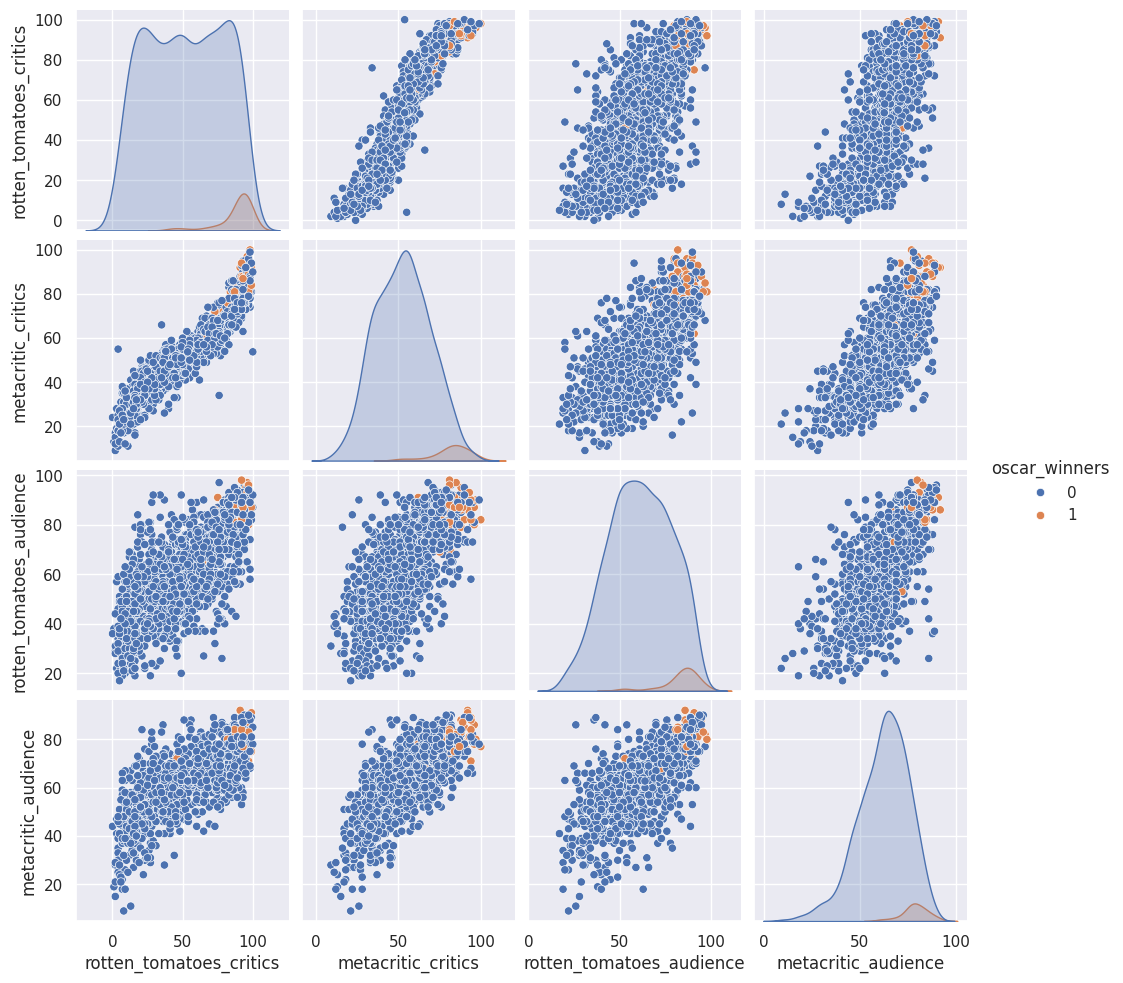

In [262]:
y = df_cl[['oscar_winners']]
# meta = df_cl['film'] 
pairplt = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience']]
sns.pairplot(pd.concat([pairplt, y], axis=1), hue='oscar_winners')
plt.show()

## 3.3 Principle Components Analysis
Εκτελούμε τον αλγόριθμο PCA για να δούμε αν τα δεδομένα μπορούν να αναπαρασταθούν σε λιγότερες διαστάσεις.

Επιλέγουμε τα πιο σημαντικά χαρακτηριστικά και υπολογίζουμε τις πιο σημαντικές διαστάσεις των Principal Components. Από το γράφημα διαπιστώνουμε ότι τα δεδομένα δεν μπορούν εύκολα να αναπαρασταθούν σε λιγότερες διαστάσεις διότι η πληροφορία είναι ομοιόμορφα μοιρασμένη.

In [263]:
x = df_cl_corr
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')

Text(0.5, 1.0, 'Scree plot')

In [264]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')

Text(0, 0.5, 'Cumulative explanied variance')

Μπορούμε να διακρίνουμε μία μικρή συσταδοποίηση των oscar winners κάνοντας plot τα πρώτα 2 principal components αλλά λόγω της πυκνότητας δεν έχουμε τα καλά αποτελέσματα.

In [265]:
sns.set_theme()
# plt.figure(figsize=(8, 6))
plt.xlabel(f'PC1 - {per_var[0]}%')
plt.ylabel(f'PC2 - {per_var[1]}%')
sns.scatterplot(data=final_df, x="PC1", y='PC2', hue='oscar_winners')

<Axes: title={'center': 'Cumulative explained variance'}, xlabel='PC1 - 16.97%', ylabel='PC2 - 8.6%'>

Επαναϋπολογίζουμε τα principal components και αυτή τη φορά κρατάμε τα n πρώτα πιο σημαντικά.

In [266]:
# Calculate PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

# 4. Συσταδοποίηση

## 4.1 KMeans
Εκτελούμε τον αλγόριθμο συσταδοποίησης KMeans σε επιλεγμένα χαρακτηριστικά.

Πρώτα χρησιμοπιούμε τη μέθοδο **Elbow** για να βρούμε τον καλύτερο αριθμό συστάδων για τα χαρακτηριστικά που επιλέξαμε.

In [267]:
#PCA features
df_kmeans_pca = df_cl[['PC1', 'PC2']]
# Select features
df_kmeans = df_cl[['metacritic_critics','rotten_tomatoes_critics']]

In [268]:
inertia = []
for i in range(2,11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_pca.fit(principal_components)
    inertia.append(kmeans_pca.inertia_)

In [269]:
plt.figure(figsize=(10,6))
sns.set_theme()
ax = sns.lineplot(x = range(2, 11), y = inertia,marker='o', markerfacecolor='black',color='black', linewidth=1)


ax.set(title='Elbow method graph', xlabel='Number of clusters', ylabel='Sum of squared errors')
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
ax.set_title(ax.get_title(), fontdict={'weight': 'bold'})

Text(0.5, 1.0, 'Elbow method graph')

Εκτελούμε την μεθοδο KMeans συσταδοποίηση με τον αριθμό των συστάδων που βρήκαμε παραπάνω.

In [270]:
# Select features for clustering
# df_kmeans_pca = df_cl[['PC1', 'PC2']]
# df_kmeans = df_cl[['metacritic_critics', 'rotten_tomatoes_critics']]


# Calculate KMeans clusters for PCA
kmeans_pca = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans_pca.fit(df_kmeans_pca)

# Calculate KMeans clusters
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans.fit(df_kmeans)


#Append clusters to dataframe
df_cl['kmeans_pca'] = kmeans_pca.labels_
df_cl['kmeans'] = kmeans.labels_

# Count clusters
kmeans_dict_pca = dict(Counter(kmeans.labels_))
kmeans_dict = dict(Counter(kmeans.labels_))


In [271]:
#Count Oscar winners in each cluster
kmeans_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['kmeans']):
    if cluster not in kmeans_oscars:
        kmeans_oscars[cluster] = 0
    kmeans_oscars[cluster] += oscar

kmeans_oscars

{2: 4, 0: 49, 3: 3, 1: 0}

Στο γράφημα μπάρας φαίνεται ο αριθμός των στοιχείων και ο αριθμός των oscar με κόκκινο σε κάθε συστάδα.

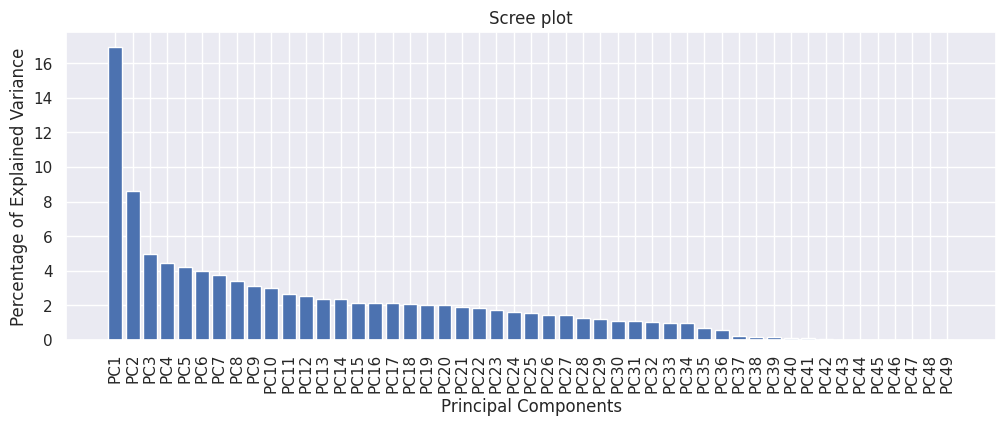

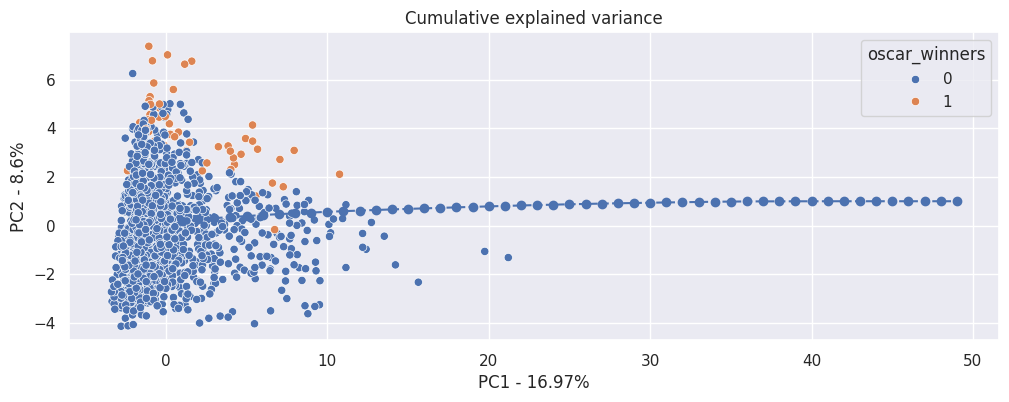

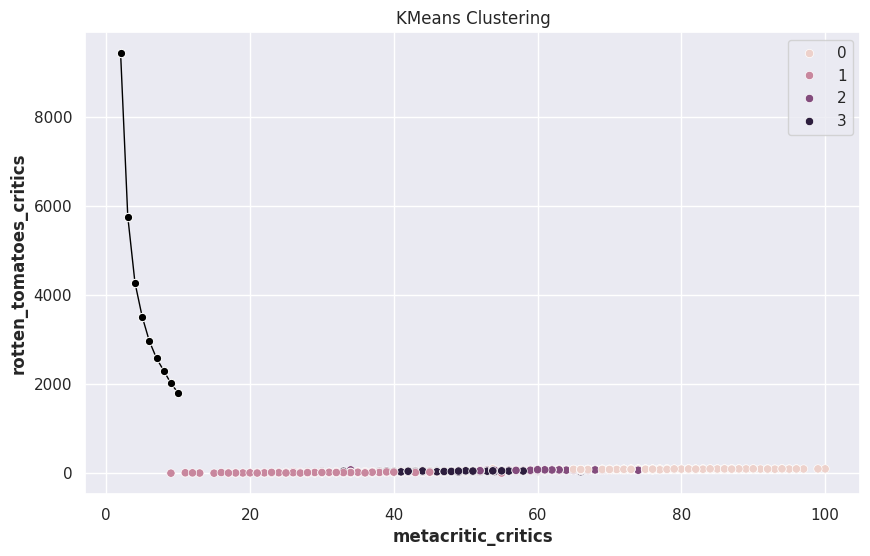

In [272]:
sns.set_theme()
# plt.figure(figsize=(8,6))
sns.scatterplot(data=df_cl, x='metacritic_critics', y='rotten_tomatoes_critics', hue='kmeans')
plt.title('KMeans Clustering')
plt.xlabel('metacritic_critics')
plt.ylabel('rotten_tomatoes_critics')
plt.legend()
plt.show()

## 4.2 DBSCAN
Εκτελούμε τον αλγόριθμο συσταδοποίησης DBSCAN σε επιλεγμένα χαρακτηριστικά.

In [273]:
# Select columns for DBSCAN
df_dbscan = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience', 'oscar_winners'] ]

X_dbscan = df_dbscan.drop(['oscar_winners'], axis=1)

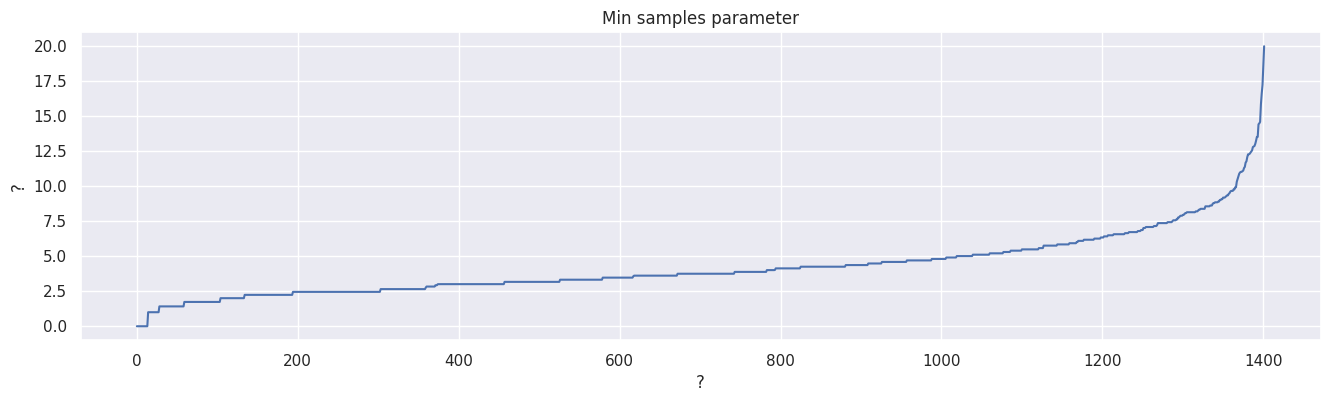

In [274]:
# Find min samples parameter
neighbors = NearestNeighbors(n_neighbors=8)
neighbors_fit = neighbors.fit(X_dbscan)
distances, indices = neighbors_fit.kneighbors(X_dbscan)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('Min samples parameter')
plt.xlabel('?')
plt.ylabel('?')
plt.show()

In [275]:
# Calculate dbscan clusters
dbscan = DBSCAN(eps=10, min_samples=8).fit(X_dbscan)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

df_cl['dbscan'] = dbscan.labels_

labels_list = dbscan.labels_.tolist()
n_noise_ = labels_list.count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

Estimated number of clusters: 2
Estimated number of noise points: 87


In [276]:
dbscan_dict = dict(Counter(dbscan.labels_))
dbscan_dict

{0: 1304, 1: 11, -1: 87}

In [277]:
# Count oscar winners in each cluster
dbscan_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['dbscan']):
    if cluster not in dbscan_oscars:
        dbscan_oscars[cluster] = 0
    dbscan_oscars[cluster] += oscar

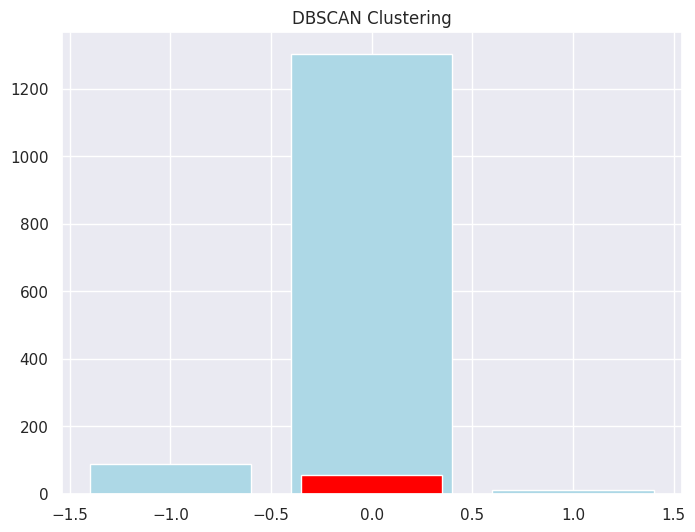

In [278]:
cluster_frequencies = Counter(dbscan.labels_)

labels = []
for item in set(dbscan.labels_):
    labels.append(item)

numbers = []
for key in dbscan_dict:
     numbers.append(dbscan_dict[key])

oscar = []
for key in dbscan_oscars:
     oscar.append(dbscan_oscars[key])
     
sns.set_theme()

plt.figure(figsize=(8,6))
plt.bar(labels, numbers, color='lightblue')
plt.bar(labels, oscar, width=0.7, color='red')
plt.title('DBSCAN Clustering')
plt.show()

## 4.3 Agglomerative Clustering
Εκτελούμε τον αλγόριθμο συσταδοποίησης Agglomerative σε επιλεγμένα χαρακτηριστικά.

In [279]:
# Select features
df_aglm = df_dbscan
X_aglm = X_dbscan

In [280]:
# Calculate agg
agg=AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(X_aglm)

df_cl['agg'] = agg.labels_

In [281]:
agg_dict = dict(Counter(agg.labels_))
agg_dict

{0: 809, 1: 593}

In [282]:
# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['agg']):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

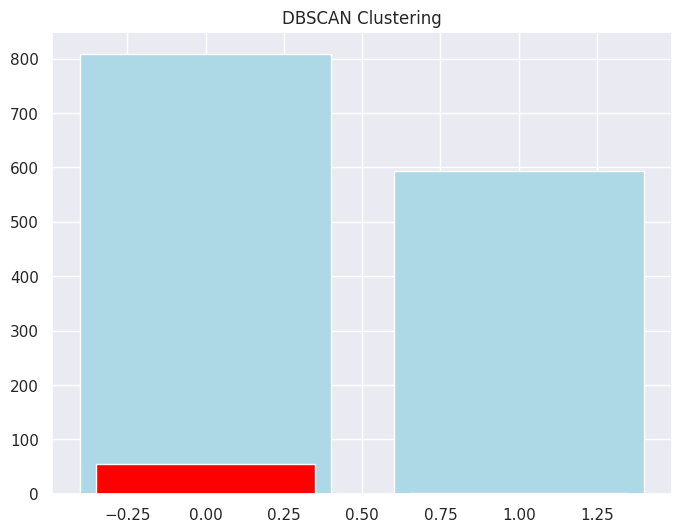

In [283]:
cluster_frequencies = Counter(agg.labels_)

labels = []
for item in set(agg.labels_):
    labels.append(item)

numbers = []
for key in agg_dict:
     numbers.append(agg_dict[key])

oscar = []
for key in agg_oscars:
     oscar.append(agg_oscars[key])
     

sns.set_theme()
plt.figure(figsize=(8,6))
plt.bar(labels, numbers, color='lightblue')
plt.bar(labels, oscar, width=0.7, color='red')
plt.title('DBSCAN Clustering')
plt.show()

## 4.4 Αξιολόγηση αλγόριθμων συσταδοποίησης



# 5. Μοντέλα προβλέψεων - τεχνικές αντιμετώπισης ανισσόροπων δεδομένων

https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/#h-3-smote

## 5.1 Νευρωνικό δίκτυο

In [284]:
# remove unecessesary features from dataset
df_nn = df_cl.drop(['film','year','opening_weekend', 'domestic_gross', 'foreign_gross', 'worldwide_gross', 'rotten_tomatoes_vs_metacritic_deviance', 
                    'audience_vs_critics_deviance', 'worldwide_gross_($million)', 'of_gross_earned_abroad', 'average_audience', 'average_critics', 
                    'budget_recovered', 'budget_recovered_opening_weekend', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)',
                    'oscar_detail','PC1','PC2','kmeans_pca','kmeans','dbscan','agg'], axis=1)

In [285]:
# Separate testing split from dataset
df_nn_train, df_nn_test = train_test_split(df_nn, test_size=0.2, stratify=df_nn['oscar_winners'])

# Separate classes
df_nn_majority = df_nn_train[(df_nn_train['oscar_winners']==0)].reset_index().drop('index', axis=1)
df_nn_minority = df_nn_train[(df_nn_train['oscar_winners']==1)].reset_index().drop('index', axis=1)

### 5.1.1 Upsampling

In [286]:
df_nn_minority_upsampled = resample(df_nn_minority, replace=True, n_samples= len(df_nn_majority), random_state=42)

df_nn_minority_upsampled = df_nn_minority_upsampled.reset_index().drop('index', axis=1)

df_nn_upsampled = pd.concat([df_nn_minority_upsampled, df_nn_majority]).sort_index(kind='merge')
df_nn_upsampled = df_nn_upsampled.reset_index().drop('index', axis=1)

#### Εκπαίδευση μοντέλου

In [287]:
# Prepare dataset for training k-fold splits
X = df_nn_upsampled.drop(['oscar_winners'], axis=1)
y = df_nn_upsampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_ups_nn = []
for train_idx, valid_idx in kf.split(X, y):

    train, validate = df_nn_upsampled.iloc[train_idx], df_nn_upsampled.iloc[valid_idx]
    # separate labels and convert to tensor
    X_train, y_train = torch.tensor(train.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(train[['oscar_winners']].values, dtype=torch.float32) 
    X_valid, y_valid = torch.tensor(validate.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(validate[['oscar_winners']].values, dtype=torch.float32)

    model = OscarClassificationNeuralNetwork(input_features=X_train.shape[1], 
                                                hidden_layer_input_features = X_train.shape[1],
                                                hidden_layer_output_features = X_train.shape[1],
                                                device='cpu',                                               
                                                learning_rate=0.01)
    
    train_progress = model.fit(accuracy_fn, X_train, y_train, X_valid, y_valid, epochs=100, seed=None, verbose=True)
    
    # Test on test split
    X_test, y_test = torch.tensor(df_nn_test.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(df_nn_test[['oscar_winners']].values, dtype=torch.float32)
    y_pred, acc = model.test(accuracy_fn, X_test, y_test)

    report = classification_report(y_test, torch.round(torch.sigmoid(y_pred)), output_dict=True, zero_division=0.0)
    reports_ups_nn.append({'label' : 'Upsampling',
                            'report':report,
                            'true' : y_test.to('cpu').numpy(),
                            'preds' : y_pred.to('cpu').numpy()})

best_performing_ups_nn_model = max(reports_ups_nn, key=lambda a:a['report']['1.0']['f1-score'])

Epoch: 0000 | Loss: 17.7825, Acc: 0.50 | Test Loss: 12.4951, Test Acc: 0.50
Epoch: 0010 | Loss: 0.8448, Acc: 0.52 | Test Loss: 1.2600, Test Acc: 0.52
Epoch: 0020 | Loss: 0.6024, Acc: 0.76 | Test Loss: 1.8400, Test Acc: 0.73
Epoch: 0030 | Loss: 1.6551, Acc: 0.77 | Test Loss: 1.5185, Test Acc: 0.81
Epoch: 0040 | Loss: 0.4165, Acc: 0.81 | Test Loss: 0.3741, Test Acc: 0.83
Epoch: 0050 | Loss: 0.4002, Acc: 0.85 | Test Loss: 0.3332, Test Acc: 0.86
Epoch: 0060 | Loss: 0.5334, Acc: 0.88 | Test Loss: 0.4628, Test Acc: 0.89
Epoch: 0070 | Loss: 0.5412, Acc: 0.91 | Test Loss: 0.6296, Test Acc: 0.92
Epoch: 0080 | Loss: 0.7060, Acc: 0.92 | Test Loss: 1.2018, Test Acc: 0.94


Epoch: 0090 | Loss: 0.4189, Acc: 0.93 | Test Loss: 0.6941, Test Acc: 0.94
Epoch: 0099 | Loss: 0.2530, Acc: 0.90 | Test Loss: 0.2679, Test Acc: 0.91
Test total accuracy: 0.8968
Epoch: 0000 | Loss: 6.8559, Acc: 0.50 | Test Loss: 10.8437, Test Acc: 0.50
Epoch: 0010 | Loss: 2.0942, Acc: 0.71 | Test Loss: 0.6138, Test Acc: 0.69
Epoch: 0020 | Loss: 2.1131, Acc: 0.77 | Test Loss: 0.5416, Test Acc: 0.78
Epoch: 0030 | Loss: 0.7579, Acc: 0.75 | Test Loss: 0.4524, Test Acc: 0.79
Epoch: 0040 | Loss: 0.7549, Acc: 0.82 | Test Loss: 0.3764, Test Acc: 0.83
Epoch: 0050 | Loss: 0.4906, Acc: 0.84 | Test Loss: 0.3457, Test Acc: 0.85
Epoch: 0060 | Loss: 0.4251, Acc: 0.86 | Test Loss: 0.3062, Test Acc: 0.85
Epoch: 0070 | Loss: 0.2740, Acc: 0.90 | Test Loss: 0.2696, Test Acc: 0.88
Epoch: 0080 | Loss: 0.3516, Acc: 0.85 | Test Loss: 0.3372, Test Acc: 0.81
Epoch: 0090 | Loss: 0.3621, Acc: 0.82 | Test Loss: 0.3021, Test Acc: 0.85
Epoch: 0099 | Loss: 0.4199, Acc: 0.82 | Test Loss: 0.4247, Test Acc: 0.76
Test tota

#### 5.1.1a Πρόοδος εκπαίδευσης

In [288]:
# Select best dataset balance performance from experiment 2
# best_preds = max(results_nn_2, key=lambda a:a['classification_report']['1.0']['f1-score'])

# Plot training accuracy
# sns.reset_orig()
# sns.set_theme()
# plt.plot([d['epoch'] for d in best_performing_nn_model['acc_prog']], [d['train_acc'] for d in best_performing_nn_model['acc_prog']], label='Train data')
# plt.plot([d['epoch'] for d in best_performing_nn_model['acc_prog']], [d['test_acc'] for d in best_performing_nn_model['acc_prog']], 'r--', label='Test data')
# plt.title('Training accuracy progress - Neural Network')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# # plt.ylim(0,1)
# plt.legend()
# plt.show()

#### 5.1.1b Καμπύλη ROC

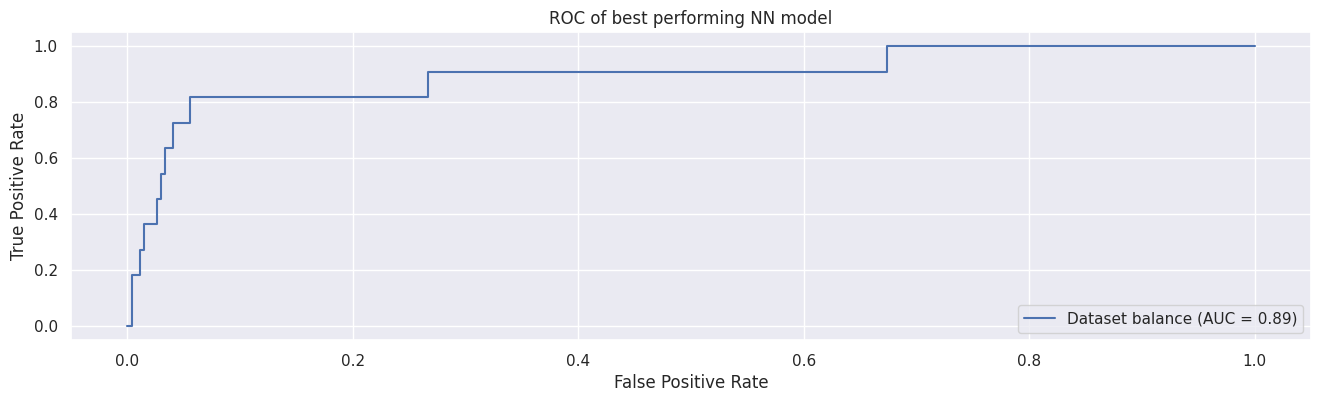

In [289]:
best_y_true = best_performing_ups_nn_model['true'].flatten()
best_y_pred = best_performing_ups_nn_model['preds'].flatten()

fpr, tpr, thresholds = roc_curve(best_y_true, best_y_pred)
roc_auc = auc(fpr, tpr)

# sns.reset_orig()
sns.set_theme()
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f"Dataset balance")
display.plot()
plt.title('ROC of best performing NN model')
plt.show()

#### 5.1.1c Πίνακας σύγχησης

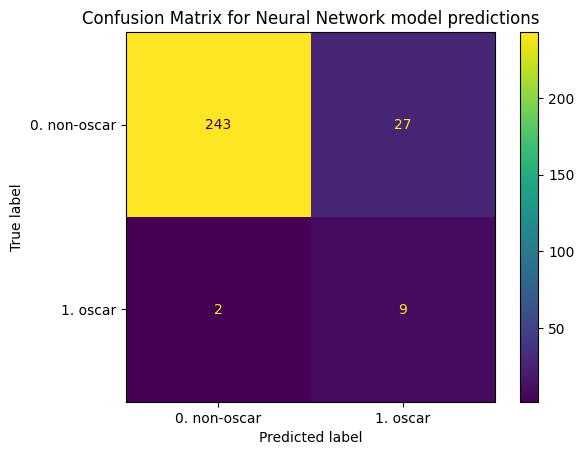

In [290]:
y_test, y_test_pred = torch.round(torch.tensor((best_y_true))), torch.round(torch.tensor((best_y_pred)))
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.reset_orig()
# sns.set_theme()
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['0. non-oscar','1. oscar'])
disp.plot()
plt.title('Confusion Matrix for Neural Network model predictions')
plt.show()

#### 5.1.1d Αξιολόγηση κατηγοριοποίησης

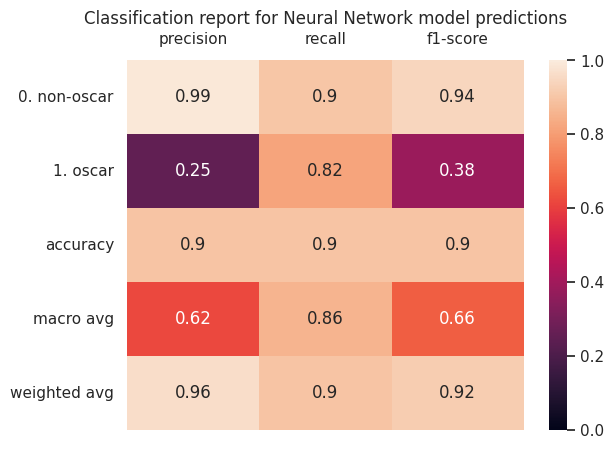

In [291]:
clf_report = classification_report(y_test, y_test_pred, output_dict=True, target_names=['0. non-oscar', '1. oscar'])

# sns.reset_orig()
sns.set_theme()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, vmin=0, vmax=1)
plt.title('Classification report for Neural Network model predictions')
plt.tick_params(labelbottom = False, labeltop=True)
plt.show()

### 5.1.2 Downsampling

In [292]:
df_nn_majority_downsampled = resample(df_nn_majority, replace=True, n_samples= len(df_nn_minority), random_state=42)

df_nn_majority_downsampled = df_nn_majority_downsampled.reset_index().drop('index', axis=1)

df_nn_downsampled = pd.concat([df_nn_majority_downsampled, df_nn_minority]).sort_index(kind='merge')
df_nn_downsampled = df_nn_downsampled.reset_index().drop('index', axis=1)

#### Εκπαίδευση μοντέλου

In [293]:
# Prepare dataset for training k-fold splits
X = df_nn_downsampled.drop(['oscar_winners'], axis=1)
y = df_nn_downsampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_dwn_nn = []
for train_idx, valid_idx in kf.split(X, y):

    train, validate = df_nn_downsampled.iloc[train_idx], df_nn_downsampled.iloc[valid_idx]
    # separate labels and convert to tensor
    X_train, y_train = torch.tensor(train.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(train[['oscar_winners']].values, dtype=torch.float32) 
    X_valid, y_valid = torch.tensor(validate.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(validate[['oscar_winners']].values, dtype=torch.float32)

    model = OscarClassificationNeuralNetwork(input_features=X_train.shape[1], 
                                                hidden_layer_input_features = X_train.shape[1],
                                                hidden_layer_output_features = X_train.shape[1],
                                                device='cpu',                                               
                                                learning_rate=0.01)
    
    train_progress = model.fit(accuracy_fn, X_train, y_train, X_valid, y_valid, epochs=100, seed=None, verbose=True)
    
    # Test on test split
    X_test, y_test = torch.tensor(df_nn_test.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(df_nn_test[['oscar_winners']].values, dtype=torch.float32)
    y_pred, acc = model.test(accuracy_fn, X_test, y_test)

    report = classification_report(y_test, torch.round(torch.sigmoid(y_pred)), output_dict=True, zero_division=0.0)
    reports_dwn_nn.append({ 'label' : 'Downsampling',
                            'report':report,
                            'true' : y_test.to('cpu').numpy(),
                            'preds' : y_pred.to('cpu').numpy()})

best_performing_dwn_nn_model = max(reports_dwn_nn, key=lambda a:a['report']['1.0']['f1-score'])

Epoch: 0000 | Loss: 2.3732, Acc: 0.50 | Test Loss: 1.3801, Test Acc: 0.50
Epoch: 0010 | Loss: 0.7212, Acc: 0.68 | Test Loss: 0.7197, Test Acc: 0.39
Epoch: 0020 | Loss: 0.5566, Acc: 0.78 | Test Loss: 0.4758, Test Acc: 0.78
Epoch: 0030 | Loss: 0.3498, Acc: 0.88 | Test Loss: 0.2585, Test Acc: 0.83
Epoch: 0040 | Loss: 0.2151, Acc: 0.94 | Test Loss: 0.1971, Test Acc: 0.89
Epoch: 0050 | Loss: 0.1476, Acc: 0.94 | Test Loss: 0.2051, Test Acc: 0.89
Epoch: 0060 | Loss: 0.0834, Acc: 1.00 | Test Loss: 0.2464, Test Acc: 0.89
Epoch: 0070 | Loss: 0.0407, Acc: 1.00 | Test Loss: 0.3542, Test Acc: 0.89
Epoch: 0080 | Loss: 0.4697, Acc: 0.92 | Test Loss: 0.6328, Test Acc: 0.83
Epoch: 0090 | Loss: 0.1369, Acc: 0.96 | Test Loss: 0.2410, Test Acc: 0.83
Epoch: 0099 | Loss: 0.0853, Acc: 0.99 | Test Loss: 0.5834, Test Acc: 0.83
Test total accuracy: 0.7651
Epoch: 0000 | Loss: 32.2546, Acc: 0.46 | Test Loss: 1.9350, Test Acc: 0.50
Epoch: 0010 | Loss: 0.7235, Acc: 0.72 | Test Loss: 0.5199, Test Acc: 0.72
Epoch: 00

#### 5.1.2a Πρόοδος εκπαίδευσης

#### 5.1.2b Καμπύλη ROC

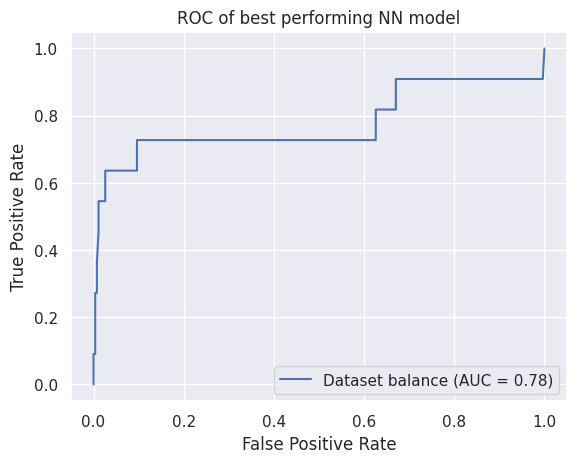

In [294]:
best_y_true = best_performing_dwn_nn_model['true'].flatten()
best_y_pred = best_performing_dwn_nn_model['preds'].flatten()

fpr, tpr, thresholds = roc_curve(best_y_true, best_y_pred)
roc_auc = auc(fpr, tpr)

# sns.reset_orig()
sns.set_theme()
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f"Dataset balance")
display.plot()
plt.title('ROC of best performing NN model')
plt.show()

#### 5.1.2c Πίνακας σύγχησης

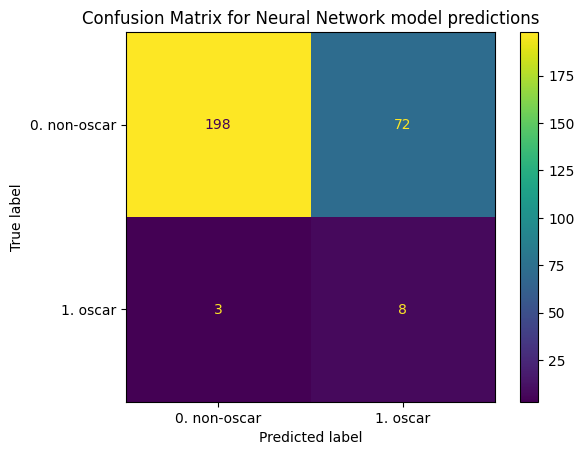

In [295]:
y_test, y_test_pred = torch.round(torch.tensor((best_y_true))), torch.round(torch.tensor((best_y_pred)))
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.reset_orig()
# sns.set_theme()
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['0. non-oscar','1. oscar'])
disp.plot()
plt.title('Confusion Matrix for Neural Network model predictions')
plt.show()

#### 5.1.2d Αξιολόγηση κατηγοριοποίησης

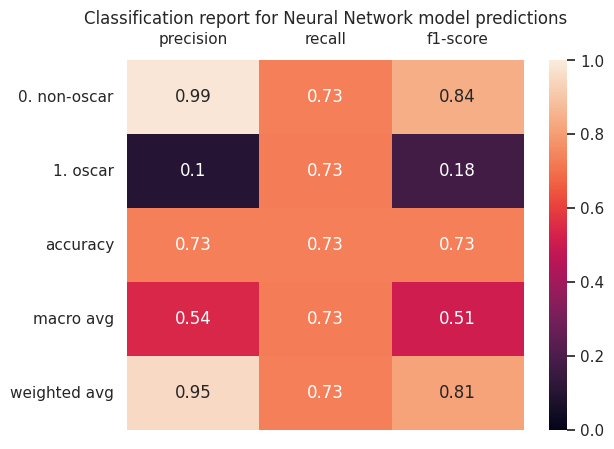

In [296]:
clf_report = classification_report(y_test, y_test_pred, output_dict=True, target_names=['0. non-oscar', '1. oscar'])

# sns.reset_orig()
sns.set_theme()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, vmin=0, vmax=1)
plt.title('Classification report for Neural Network model predictions')
plt.tick_params(labelbottom = False, labeltop=True)
plt.show()

### 5.1.3 SMOTE (Synthetic Minority Oversampling Technique)

In [297]:
sm = SMOTE(sampling_strategy='minority', random_state=42)

df_nn_oversampled_X, df_nn_oversampled_Y = sm.fit_resample(df_nn_train.drop('oscar_winners', axis=1), df_nn_train['oscar_winners'])
df_nn_oversampled = pd.concat([pd.DataFrame(df_nn_oversampled_X), pd.DataFrame(df_nn_oversampled_Y)], axis=1)

#### Εκπαίδευση μοντέλου

In [298]:
# Prepare dataset for training k-fold splits
X = df_nn_oversampled.drop(['oscar_winners'], axis=1)
y = df_nn_oversampled[['oscar_winners']]

# Create k-fold splits and stratify classes
kf = StratifiedKFold(n_splits=5, shuffle=False)

reports_smote_nn = []
for train_idx, valid_idx in kf.split(X, y):

    train, validate = df_nn_oversampled.iloc[train_idx], df_nn_oversampled.iloc[valid_idx]
    # separate labels and convert to tensor
    X_train, y_train = torch.tensor(train.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(train[['oscar_winners']].values, dtype=torch.float32) 
    X_valid, y_valid = torch.tensor(validate.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(validate[['oscar_winners']].values, dtype=torch.float32)

    model = OscarClassificationNeuralNetwork(input_features=X_train.shape[1], 
                                                hidden_layer_input_features = X_train.shape[1],
                                                hidden_layer_output_features = X_train.shape[1],
                                                device='cpu',                                               
                                                learning_rate=0.01)
    
    train_progress = model.fit(accuracy_fn, X_train, y_train, X_valid, y_valid, epochs=100, seed=None, verbose=True)
    
    # Test on test split
    X_test, y_test = torch.tensor(df_nn_test.drop(['oscar_winners'], axis=1).values, dtype=torch.float32), torch.tensor(df_nn_test[['oscar_winners']].values, dtype=torch.float32)
    y_pred, acc = model.test(accuracy_fn, X_test, y_test)

    report = classification_report(y_test, torch.round(torch.sigmoid(y_pred)), output_dict=True, zero_division=0.0)
    reports_smote_nn.append({'label':'SMOTE',
                            'report':report,
                            'true' : y_test.to('cpu').numpy(),
                            'preds' : y_pred.to('cpu').numpy()})

best_performing_smote_nn_model = max(reports_smote_nn, key=lambda a:a['report']['1.0']['f1-score'])

Epoch: 0000 | Loss: 2.5847, Acc: 0.53 | Test Loss: 19.2613, Test Acc: 0.44
Epoch: 0010 | Loss: 1.3060, Acc: 0.63 | Test Loss: 3.0087, Test Acc: 0.73
Epoch: 0020 | Loss: 3.2699, Acc: 0.67 | Test Loss: 0.6700, Test Acc: 0.75
Epoch: 0030 | Loss: 2.3276, Acc: 0.64 | Test Loss: 1.6081, Test Acc: 0.84
Epoch: 0040 | Loss: 1.0210, Acc: 0.72 | Test Loss: 1.2751, Test Acc: 0.72
Epoch: 0050 | Loss: 0.8273, Acc: 0.84 | Test Loss: 0.4925, Test Acc: 0.86
Epoch: 0060 | Loss: 0.6123, Acc: 0.87 | Test Loss: 1.5035, Test Acc: 0.85
Epoch: 0070 | Loss: 0.6417, Acc: 0.90 | Test Loss: 1.2318, Test Acc: 0.90
Epoch: 0080 | Loss: 0.2744, Acc: 0.91 | Test Loss: 0.4003, Test Acc: 0.89
Epoch: 0090 | Loss: 0.2770, Acc: 0.93 | Test Loss: 0.5529, Test Acc: 0.92
Epoch: 0099 | Loss: 0.3991, Acc: 0.94 | Test Loss: 0.6585, Test Acc: 0.92
Test total accuracy: 0.8826
Epoch: 0000 | Loss: 7.6535, Acc: 0.54 | Test Loss: 61.4873, Test Acc: 0.50
Epoch: 0010 | Loss: 3.1797, Acc: 0.68 | Test Loss: 10.2946, Test Acc: 0.63
Epoch: 

#### 5.1.3a Πρόοδος εκπαίδευσης

In [299]:
# Select best dataset balance performance from experiment 2
# best_preds = max(results_nn_2, key=lambda a:a['classification_report']['1.0']['f1-score'])

# # Plot training accuracy
# # sns.reset_orig()
# sns.set_theme()
# plt.plot([d['epoch'] for d in best_preds['acc_prog']], [d['train_acc'] for d in best_preds['acc_prog']], label='Train data')
# plt.plot([d['epoch'] for d in best_preds['acc_prog']], [d['test_acc'] for d in best_preds['acc_prog']], 'r--', label='Test data')
# plt.title('Training accuracy progress - Neural Network')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# # plt.ylim(0,1)
# plt.legend()

#### 5.1.2b Καμπύλη ROC

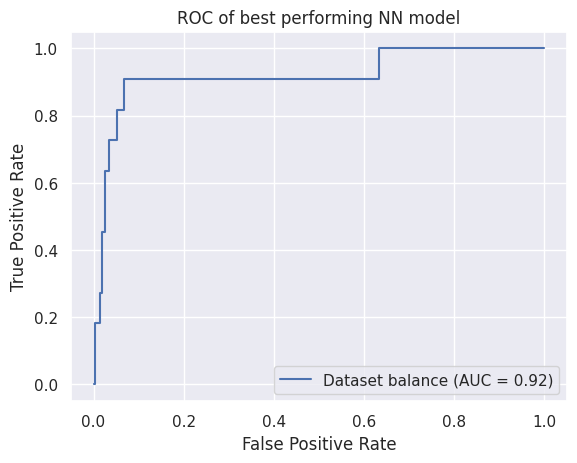

In [300]:
y_true = best_performing_smote_nn_model['true'].flatten()
y_pred = best_performing_smote_nn_model['preds'].flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# sns.reset_orig()
sns.set_theme()
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f"Dataset balance")
display.plot()
plt.title('ROC of best performing NN model')
plt.show()

#### 5.1.2c Πίνακας σύγχησης

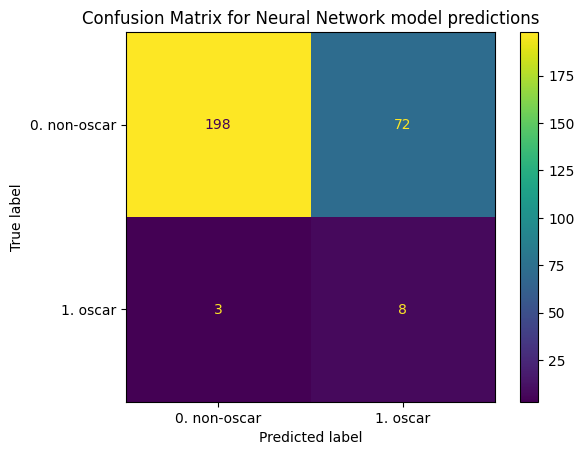

In [301]:
y_test, y_test_pred = torch.round(torch.tensor((best_y_true))), torch.round(torch.tensor((best_y_pred)))
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.reset_orig()
# sns.set_theme()
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['0. non-oscar','1. oscar'])
disp.plot()
plt.title('Confusion Matrix for Neural Network model predictions')
plt.show()

#### 5.1.2d Αξιολόγηση κατηγοριοποίησης

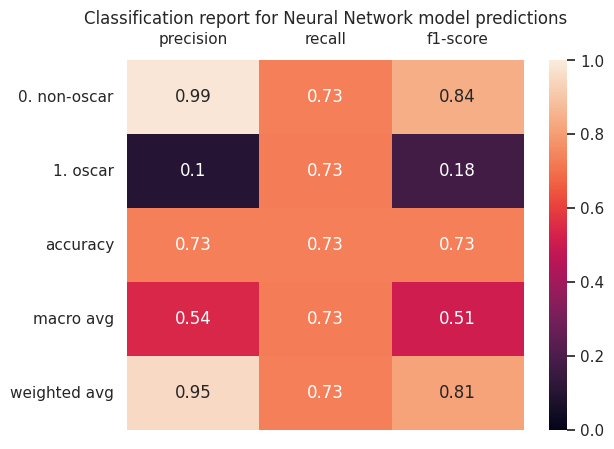

In [302]:
clf_report = classification_report(y_test, y_test_pred, output_dict=True, target_names=['0. non-oscar', '1. oscar'])

# sns.reset_orig()
sns.set_theme()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, vmin=0, vmax=1)
plt.title('Classification report for Neural Network model predictions')
plt.tick_params(labelbottom = False, labeltop=True)
plt.show()

# Plotting tests

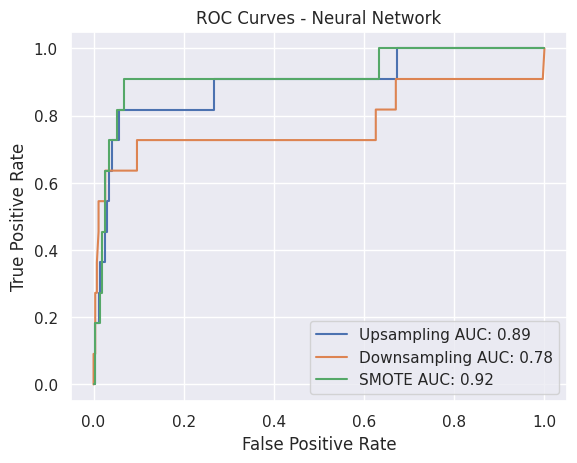

In [303]:
plot_roc_curves(best_performing_ups_nn_model, best_performing_dwn_nn_model, best_performing_smote_nn_model,'ROC Curves - Neural Network')

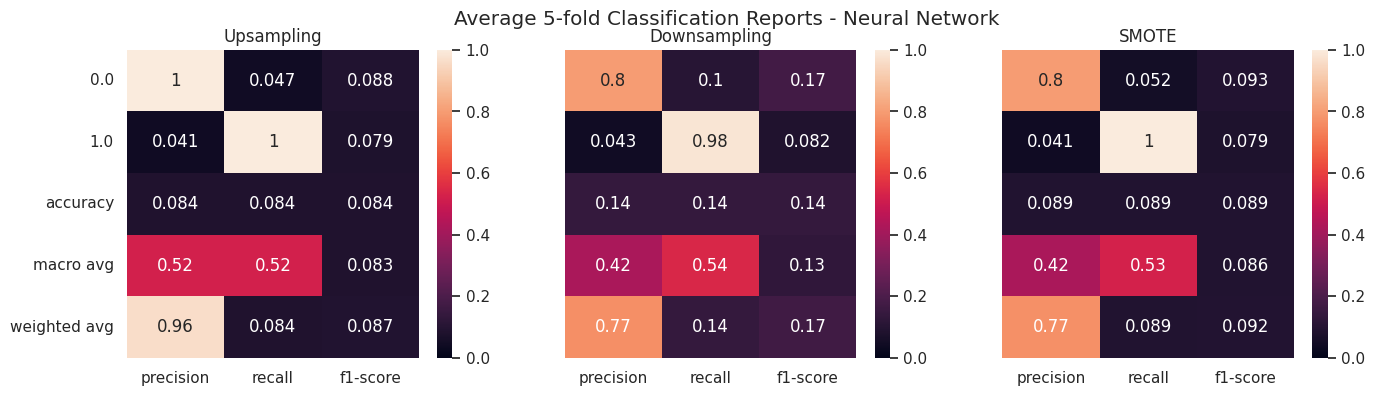

In [319]:
avg_classification_reports((reports_ups_nn, reports_dwn_nn, reports_smote_nn),'Average 5-fold Classification Reports - Neural Network')

### Errorbars plot **

In [163]:
# error_bars_min = []
# error_bars_max = []
# x_points = []
# y_points = []

# for ratio in balance_ratios:
#     scores = []
#     for item in results_nn:
#         if item['ratio'] == ratio:
#             # scores.append(item['classification_report']['accuracy'])
#             scores.append(item['accuracy'])
    
#     x_points.append(ratio)
#     y_points.append(np.average(scores))
#     error_bars_min.append(min(scores))
#     error_bars_max.append(max(scores))

# error_bars = [[],[]]

# for min_p, max_p, center in zip(error_bars_min, error_bars_max, y_points):
#     error_bars[0].append(center - min_p)
#     error_bars[1].append(max_p - center)

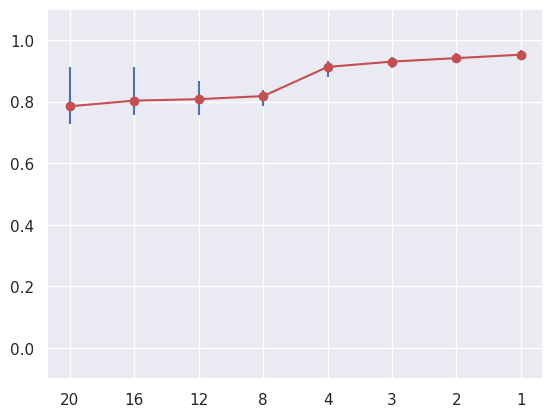

In [169]:
# fig, ax = plt.subplots()
# ax.plot(range(len(x_points)), y_points, 'r-')

# ax.errorbar(range(len(x_points)), y_points, xerr=0, yerr=error_bars, ecolor = 'b',fmt='ro')
# ax.set_xticks(range(len(x_points)), [str(x) for x in x_points])
# ax.set_ylim(-0.1, 1.1)
# plt.show()

## 5.2 K-Nearest Neighbors classification model

### 5.2.1 Ετοιμασία δεδομένων

In [175]:
df_knn = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'opening_weekend_($million)', 'domestic_gross_($million)',
       'foreign_gross_($million)', 'budget_($million)', 'oscar_winners']]

### 5.2.2 Πείραμα 1 - Αναζήτηση καλύτερου λόγου ισορροπίας δεδομένων

In [176]:
# Class balance ratios to train
balance_ratios = [20, 16, 12, 8, 4, 3, 2, 1]

data_report_knn = {
    'model': 'K-Nearest Neighbors',
    '1_recall': [],
    '1_f1-score' : [],
    'accuracy' : [],
    # 'point_labels': [],
    'n_balance_datasets' : len(balance_ratios)
    }

# Separate oscar winners from non-oscar winners
oscar_movies = df_knn[df_knn['oscar_winners'] == 1]
non_oscar_movies = df_knn[df_knn['oscar_winners'] == 0]

results_knn = []
for ratio in balance_ratios:
    # Select balance
    df_knn_balanced = pd.concat([oscar_movies, non_oscar_movies.sample(n=(ratio * oscar_movies.shape[0]))], axis=0)

    # Prepare dataset for training k-fold splits
    X_knn = df_knn_balanced.iloc[:, :-1].values
    y_knn = df_knn_balanced.iloc[:, -1].values

    # Find optimal number of neighbours for our data
    k_values = [i for i in range (2,31)]
    scores = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        score = cross_val_score(knn, X_knn, y_knn, cv=5)
        scores.append(np.mean(score))
    best_index = np.argmax(scores)
    best_k = k_values[best_index]
    best_k

    # Create k-fold splits and stratify classes
    kf = StratifiedKFold(n_splits=5)
    
    # Get train, test splits
    # for train_idx, test_idx in tqdm(kf.split(X_knn, y_knn), total=kf.get_n_splits(X_knn, y_knn)):
    for train_idx, test_idx in kf.split(X_knn, y_knn):
        train, test = df_knn_balanced.iloc[train_idx], df_knn_balanced.iloc[test_idx]
        X_train_knn, y_train_knn = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
        X_test_knn, y_test_knn = test.drop(['oscar_winners'], axis=1).values, test[['oscar_winners']].values

        # Remove extra dimension from labels
        y_train_knn = y_train_knn.squeeze(axis=1)
        y_test_knn = y_test_knn.squeeze(axis=1)

        # Initialize and fit model
        model_knn = KNeighborsClassifier(n_neighbors=best_k)
        model_knn.fit(X_train_knn, y_train_knn)

        # Test on test split
        y_pred_knn = model_knn.predict(X_test_knn)       
        accuracy = metrics.accuracy_score(y_test_knn, y_pred_knn)

        report = classification_report(y_test_knn, y_pred_knn, output_dict=True, zero_division=0.0)
        # print(report)
        results_knn.append({'balance' : f'{ratio}:1',
                            'ratio' : ratio,
                            'best_k' : best_k, 
                            'accuracy' : accuracy,
                            'true' : y_test_knn,
                            'preds' : y_pred_knn,
                            'pred_oscar_count' : int(y_pred_knn.sum().item()), 
                            'truth_oscar_count' : int(y_test_knn.sum().item()),
                            'classification_report' : report
                        })

    # calculate average metrics between k-folds for a selected balance
    data_report_knn['1_recall'].append(np.average([x['classification_report']['1']['precision'] for x in results_knn if x['balance'] == f'{ratio}:1']))
    data_report_knn['1_f1-score'].append(np.average([x['classification_report']['1']['f1-score'] for x in results_knn if x['balance'] == f'{ratio}:1']))
    data_report_knn['accuracy'].append(np.average([x['accuracy'] for x in results_knn[-5:-1]]))

# Add results to experiment A list
exp_a_data.append(data_report_knn)

### 5.2.3 Πείραμα 2 - Επαναληπτική εκπαίδευση και έλεγχος επιδόσεων

In [177]:
# Select best performing model dataset balance from previous experiment
best_performing_model = max(results_knn, key=lambda a:a['classification_report']['1']['f1-score'])

# Balance classes
oscar_movies = df_knn[df_knn['oscar_winners'] == 1]
non_oscar_movies = df_knn[df_knn['oscar_winners'] == 0]
df_knn_balanced = pd.concat([oscar_movies, non_oscar_movies.sample(n=(int(best_performing_model['ratio']) * len(oscar_movies)))], axis=0)

# Separate features and labels
X_knn = df_knn_balanced.iloc[:, :-1].values
y_knn = df_knn_balanced.iloc[:, -1].values

# Split training and testing
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.3, stratify=y_knn)

iterations = 10

results_knn_2 = []
# Create loop for the experiment
for i in range(iterations):

    # Initialize and fit model
    model_knn = KNeighborsClassifier(n_neighbors=best_performing_model['best_k'])
    model_knn.fit(X_train_knn, y_train_knn)

    # Test on test split
    y_pred_knn = model_knn.predict(X_test_knn)
    y_prob_knn = model_knn.predict_proba(X_test_knn)

    # Calculate metrics for evaluation
    accuracy = metrics.accuracy_score(y_test_knn, y_pred_knn)
    report = classification_report(y_test_knn, y_pred_knn, output_dict=True, zero_division=0.0)

    results_knn_2.append({'iteration' : f'{i+1}',
                        'best_k' : best_performing_model['best_k'],
                        'accuracy' : accuracy,
                        'true' : y_test_knn,
                        'preds' : y_pred_knn,
                        'probs' : np.array([max(x) for x in y_prob_knn]),
                        'pred_oscar_count' : int(y_pred_knn.sum().item()), 
                        'truth_oscar_count' : int(y_test_knn.sum().item()),
                        'classification_report' : report
                    })

# Add results to experiment b list
exp_b_data.append({'model': 'K-Nearest Neighbors',
                   '1_recall': np.average([x['classification_report']['1']['recall'] for x in results_knn_2]),
                   '1_f1-score' : np.average([x['classification_report']['1']['f1-score'] for x in results_knn_2]),
                   'accuracy' : np.average([x['accuracy'] for x in results_knn_2]),
                   'iterations' : iterations
                })

### 5.2.4 Αξιολόγηση KNN μοντέλου με βάση το πείραμα 2

Καμπύλη ROC

0.31833910034602075


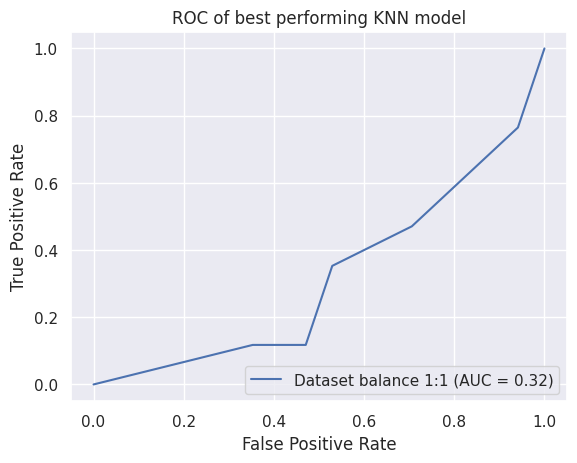

In [178]:
best_preds = max(results_knn_2, key=lambda a:a['classification_report']['1']['f1-score'])

y_true = best_preds['true']
y_pred = best_preds['probs']

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)
# sns.reset_orig()
sns.set_theme()
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Dataset balance ' + best_performing_model['balance'])
display.plot()
plt.title('ROC of best performing KNN model')
plt.show()

Πίνακας σύγχησης

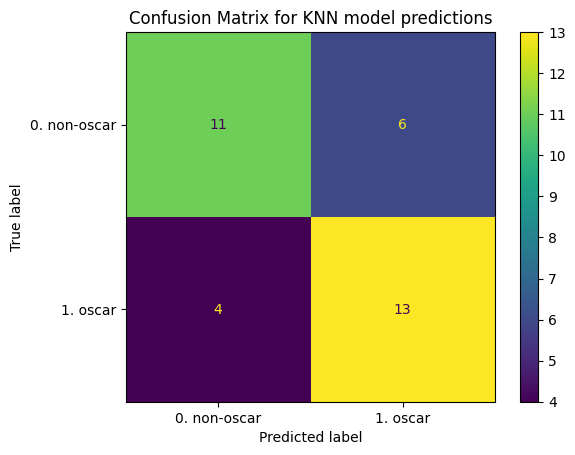

In [179]:
y_test, y_test_pred = best_preds['true'], best_preds['preds']
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.reset_orig()
# sns.set_theme()
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['0. non-oscar','1. oscar'])
disp.plot()
plt.title('Confusion Matrix for KNN model predictions')
plt.show()

Αναφορά ταξινόμησης καλύτερου μοντέλου.

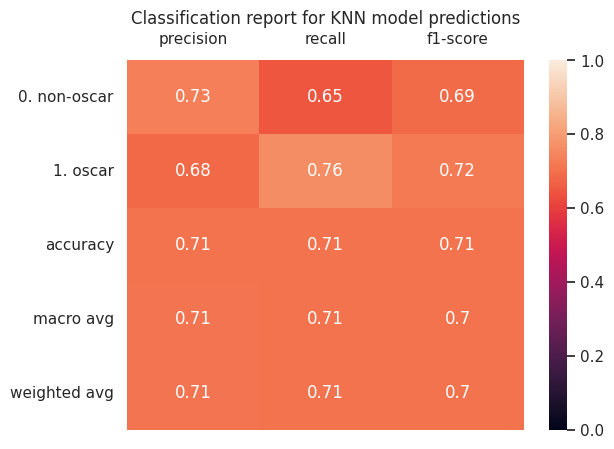

In [180]:
clf_report = classification_report(y_test, y_test_pred, output_dict=True, target_names=['0. non-oscar', '1. oscar'])

# sns.reset_orig()
sns.set_theme()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, vmin=0, vmax=1)
plt.title('Classification report for KNN model predictions')
plt.tick_params(labelbottom = False, labeltop=True)
plt.show()

## 5.3 Decision Tree

### 5.3.1 Ετοιμασία δεδομένων

In [181]:
df_dt = df_cl[['metacritic_critics', 'opening_weekend_($million)',
               'domestic_gross_($million)', 'foreign_gross_($million)',
               'oscar_winners']]

In [182]:
df_oscar_winners = df_dt[df_dt["oscar_winners"] == 1]
df_rest = df_dt[df_dt["oscar_winners"] != 1]
df_rest = df_rest.sample(n=54, random_state=42)
df_dt_balanced = pd.concat([df_oscar_winners, df_rest], axis=0)

In [183]:
X_dt = df_dt_balanced.iloc[:, :-1].values
y_dt = df_dt_balanced.iloc[:, -1].values

### 5.3.2 Εύρεση κατάλληλων υπερπαραμέτρων

In [184]:
results_dt_min_s_l = []

for i in range(40):
    X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size = 0.2, stratify=y_dt, random_state=42)

    dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_leaf=i + 1)

    dt_classifier.fit(X_train_dt, y_train_dt)

    dt_preds = dt_classifier.predict(X_test_dt)

    accuracy = metrics.accuracy_score(y_test_dt, dt_preds)
    recall = metrics.recall_score(y_test_dt, dt_preds, average='weighted')
    precision = metrics.precision_score(y_test_dt, dt_preds, average='weighted')
    f1 = metrics.f1_score(y_test_dt, dt_preds, average='weighted')
    
    results_dt_min_s_l.append({'model' : f'model_dt_{i+1}',
                    'min_samples_leaf' : i +1,
                    'accuracy' : accuracy,
                    'recall' : recall,
                    'precision' : precision,
                    'f1' : f1,
                    'preds' : dt_preds, 
                    'pred_oscar_count' : int(dt_preds.sum().item()), 
                    'truth_oscar_count' : int(y_test_dt.sum().item()) })

In [185]:
results_dt_max_depth = []
best = max(results_dt_min_s_l, key=lambda x:x['f1'])

for i in range(40):
    X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size = 0.2, stratify=y_dt, random_state=42)

    dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_leaf=best['min_samples_leaf'], max_depth=i +1)

    dt_classifier.fit(X_train_dt, y_train_dt)

    dt_preds = dt_classifier.predict(X_test_dt)

    accuracy = metrics.accuracy_score(y_test_dt, dt_preds)
    recall = metrics.recall_score(y_test_dt, dt_preds, average='weighted')
    precision = metrics.precision_score(y_test_dt, dt_preds, average='weighted')
    f1 = metrics.f1_score(y_test_dt, dt_preds, average='weighted')

    results_dt_max_depth.append({'model' : f'model_dt_{i+1}',
                    'max_depth' : i + 1,
                    'accuracy' : accuracy,
                    'recall' : recall,
                    'precision' : precision,
                    'f1' : f1,
                    'preds' : dt_preds, 
                    'pred_oscar_count' : int(dt_preds.sum().item()), 
                    'truth_oscar_count' : int(y_test_dt.sum().item()) })

### 5.3.3 Πείραμα 1 - Αναζήτηση καλύτερου λόγου ισορροπίας δεδομένων

In [186]:
# Class balance ratios to train
balance_ratios = [20, 16, 12, 8, 4, 3, 2, 1]

data_report_dt = {
    'model': 'Decision Tree',
    '1_recall': [],
    '1_f1-score' : [],
    'accuracy' : [],
    # 'point_labels': [],
    'n_balance_datasets' : len(balance_ratios)
    }

# Separate oscar winners from non-oscar winners
oscar_movies = df_dt[df_dt['oscar_winners'] == 1]
non_oscar_movies = df_dt[df_dt['oscar_winners'] == 0]

results_dt = []
for ratio in balance_ratios:
    # Select balance
    df_dt_balanced = pd.concat([oscar_movies, non_oscar_movies.sample(n=(ratio * oscar_movies.shape[0]))], axis=0)

    # Prepare dataset for training k-fold splits
    X_dt = df_dt_balanced.iloc[:, :-1].values
    y_dt = df_dt_balanced.iloc[:, -1].values

    # Create k-fold splits and stratify classes
    kf = StratifiedKFold(n_splits=5)
    
    # Get train, test splits
    # for train_idx, test_idx in tqdm(kf.split(X_dt, y_dt), total=kf.get_n_splits(X_dt, y_dt)):
    for train_idx, test_idx in kf.split(X_dt, y_dt):
        train, test = df_dt_balanced.iloc[train_idx], df_dt_balanced.iloc[test_idx]
        X_train_dt, y_train_dt = train.drop(['oscar_winners'], axis=1).values, train[['oscar_winners']].values
        X_test_dt, y_test_dt = test.drop(['oscar_winners'], axis=1).values, test[['oscar_winners']].values

        # Remove extra dimension from labels
        y_train_dt = y_train_dt.squeeze(axis=1)
        y_test_dt = y_test_dt.squeeze(axis=1)

        # Get best hyperparameters from previous chapter experiments
        best_depth = max(results_dt_max_depth, key=lambda x:x['f1'])
        best_samples = max(results_dt_min_s_l, key=lambda x:x['f1'])

        # Initialize and fit model with best hyperparameters
        model_dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_leaf=best_samples['min_samples_leaf'], max_depth=best_depth['max_depth'])
        model_dt.fit(X_train_dt, y_train_dt)

        # Make predictions
        dt_preds = model_dt.predict(X_test_dt)

        # Test on test split
        y_pred_dt = model_dt.predict(X_test_dt)       
        accuracy = metrics.accuracy_score(y_test_dt, y_pred_dt)

        report = classification_report(y_test_dt, y_pred_dt, output_dict=True, zero_division=0.0)
        
        results_dt.append({'balance' : f'{ratio}:1',
                            'ratio' : ratio,
                            'accuracy' : accuracy,
                            'true' : y_test_dt,
                            'preds' : y_pred_dt,
                            'pred_oscar_count' : int(y_pred_dt.sum().item()), 
                            'truth_oscar_count' : int(y_test_dt.sum().item()),
                            'classification_report' : report
                        })

    # calculate average metrics between k-folds for a selected balance
    data_report_dt['1_recall'].append(np.average([x['classification_report']['1']['precision'] for x in results_dt if x['balance'] == f'{ratio}:1']))
    data_report_dt['1_f1-score'].append(np.average([x['classification_report']['1']['f1-score'] for x in results_dt if x['balance'] == f'{ratio}:1']))
    data_report_dt['accuracy'].append(np.average([x['accuracy'] for x in results_knn[-5:-1]]))

# Add results to experiment A list
exp_a_data.append(data_report_dt)

### 5.3.4 Πείραμα 2 - Επαναληπτική εκπαίδευση και έλεγχος επιδόσεων

In [187]:
# Select best performing model dataset balance from previous experiment
best_performing_model = max(results_dt, key=lambda a:a['classification_report']['1']['f1-score'])

# Balance classes
oscar_movies = df_dt[df_dt['oscar_winners'] == 1]
non_oscar_movies = df_dt[df_dt['oscar_winners'] == 0]
df_dt_balanced = pd.concat([oscar_movies, non_oscar_movies.sample(n=(int(best_performing_model['ratio']) * len(oscar_movies)))], axis=0)

# Separate features and labels
X_dt = df_dt_balanced.iloc[:, :-1].values
y_dt = df_dt_balanced.iloc[:, -1].values

# Split training and testing
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.3, stratify=y_dt)

iterations = 10

results_dt_2 = []
for i in range(iterations):

    # Get best hyperparameters from previous chapter experiments
    best_depth = max(results_dt_max_depth, key=lambda x:x['f1'])
    best_samples = max(results_dt_min_s_l, key=lambda x:x['f1'])

    # Initialize and fit model with best hyperparameters
    model_dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_leaf=best_samples['min_samples_leaf'], max_depth=best_depth['max_depth'])
    model_dt.fit(X_train_dt, y_train_dt)

    # Test on test split
    y_pred_dt = model_dt.predict(X_test_dt)
    y_prob_dt = model_dt.predict_proba(X_test_dt)     
    accuracy = metrics.accuracy_score(y_test_dt, y_pred_dt)

    report = classification_report(y_test_dt, y_pred_dt, output_dict=True, zero_division=0.0)

    results_dt_2.append({'iteration' : f'{i+1}',
                        'accuracy' : accuracy,
                        'true' : y_test_dt,
                        'preds' : y_pred_dt,
                        'probs' : np.array([max(x) for x in y_prob_dt]),
                        'pred_oscar_count' : int(y_pred_dt.sum().item()), 
                        'truth_oscar_count' : int(y_test_dt.sum().item()),
                        'classification_report' : report
                    })


# Add results to experiment b list
exp_b_data.append({'model': 'Decision Tree',
                   '1_recall': np.average([x['classification_report']['1']['recall'] for x in results_dt_2]),
                   '1_f1-score' : np.average([x['classification_report']['1']['f1-score'] for x in results_dt_2]),
                   'accuracy' : np.average([x['accuracy'] for x in results_dt_2]),
                   'iterations' : iterations
                })

### 5.3.5 Αξιολόγηση Decision Tree μοντέλου με βάση το πείραμα 2

Καμπύλη ROC

0.05882352941176472


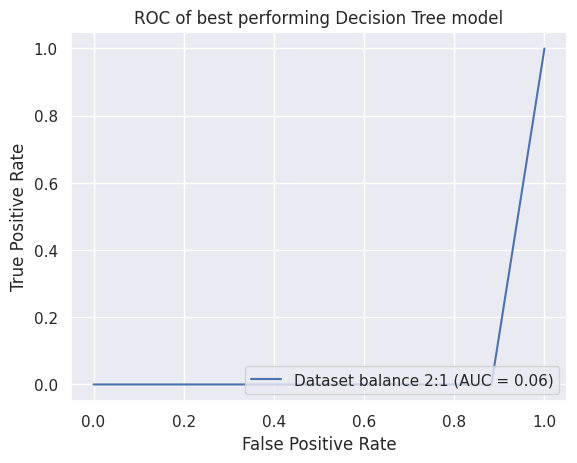

In [188]:
best_preds = max(results_dt_2, key=lambda a:a['classification_report']['1']['f1-score'])

y_true = best_preds['true']
y_pred = best_preds['probs']

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)
# sns.reset_orig()
sns.set_theme()
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Dataset balance ' + best_performing_model['balance'])
display.plot()
plt.title('ROC of best performing Decision Tree model')
plt.show()

Πίνακας σύγχησης

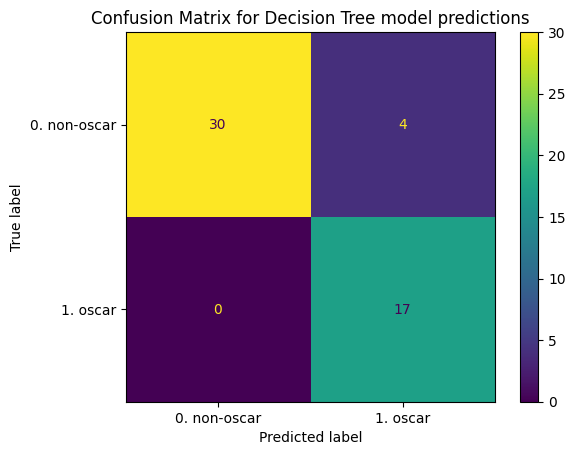

In [189]:
y_test, y_test_pred = best_preds['true'], best_preds['preds']
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.reset_orig()
# sns.set_theme()
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['0. non-oscar','1. oscar'])
disp.plot()
plt.title('Confusion Matrix for Decision Tree model predictions')
plt.show()

Αναφορά ταξινόμησης καλύτερου μοντέλου.

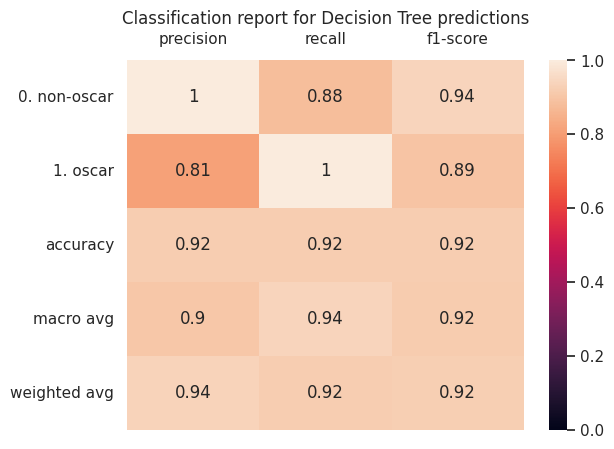

In [190]:
clf_report = classification_report(y_test, y_test_pred, output_dict=True, target_names=['0. non-oscar', '1. oscar'])

# sns.reset_orig()
sns.set_theme()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, vmin=0, vmax=1)
plt.title('Classification report for Decision Tree predictions')
plt.tick_params(labelbottom = False, labeltop=True)
plt.show()

## 5.4. Σύγκριση μοντέλων

### 5.4.x Model comparisson graphs

- Lineplot: (line for each model)
- Barplot: Recall for each n:1 balance (average for n-folds) x=number of n:1 balance datasets y=avg recall of n-fold
- ROC curves

# 6. Προβλέψεις στο άγνωστο σύνολο δεδομένων

## 6.1 Πρόβλεψη
Χρησιμοποιούμε τα εκπαιδευμένα μοντέλα κτηγοριοποίησης για να προβλέψουμε στο άγνωστο σύνολο δεδομένων αν πήραν oscar ή όχι.

In [191]:
df_un_cl_nn = df_un_cl.drop(['film','year','opening_weekend', 'domestic_gross', 'foreign_gross', 'worldwide_gross', 'rotten_tomatoes_vs_metacritic_deviance', 
                    'audience_vs_critics_deviance', 'worldwide_gross_($million)', 'of_gross_earned_abroad', 'average_audience', 'average_critics', 
                    'budget_recovered', 'budget_recovered_opening_weekend', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)', 'oscar_winners', 'oscar_detail'], axis=1)

In [196]:
X = torch.tensor(df_un_cl_nn.values, dtype=torch.float)

with torch.inference_mode():
    model.eval()
    un_nn_preds = model(X)

preds_df = pd.DataFrame(torch.round(torch.sigmoid(un_nn_preds)))

df_un_orig['neural network oscar prediction'] = preds_df